<h1 style="text-align:center;font-size:30px;" > Quora Insincere Questions Classification </h1>

**author:** ***Alejandro O. Valdés*** 
[LinkedIn](http://linkedin.com/in/aovaldes2)

*This script is ready to run as a Kaggle notebook, an essential requirement to be able to participate in this Kaggle competition.*

## Table of Content

- [Deep Learning Parameters](#parameters)
 - [Exploratory Data Analysis](#eda)
     - [Importing Libraries](#libraries)
     - [Distribution of data points among output class](#distribution)
     - [Word cloud for both sincere and insincere questions](#wordcloud)
     - [Top words in both sincere and insincere questions (Unigrams|Bigrams|Trigrams)](#gramstopwords)
     - [Basic Feauture Extraction(before cleaning)](#featureextraction1)
     - [Analysis on extracted features](#featureextractionanalysis)
 - [Machine Learning](#ml)
     - [Data Preprocessing](#datapre)
     - [Embedding](#embedding)
     - [Models](#model)
         - [TextCNN](#TextCNN)
         - [Bidirectional RNN(LSTM)](#BidirectionalLSTM)
         - [Bidirectional RNN(LSTM) II](#BidirectionalLSTMII)
     - [Blending](#Blending)
     - [Submit](#submit)
 - [Conclusion](#conclusion)

## Description

<p>An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.</p>

<p>Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.</p>

<p>In this we will develop models that identify and flag insincere questions.</p><br>

### General Description

An insincere question is defned as a question intended to make a statement rather than look for helpful answers. Some characteristics tha can signify that a question is insincere:

* Has a non-neutral tone
    * Has an exaggerated tone to underscore a point about a group of people
    * Is rhetorical and meant to impy a statement about a group of people

* Is disparaging or inflammatory
    * Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
    * Makes desparaging attacks/insults against a specific person or group of people
    * Disparages against a characteristic that is not fixable and not measurable

* Isn't grounded in reality 
    * Based on false information, or contains absurd assumptions

## __Problem Summary__

- Detect toxic content to improve online conversations.
- We have to develop models that identify and flag insincere questions.
- Source: https://www.kaggle.com/c/quora-insincere-questions-classification

<a id='parameters'></a>
## Deep Learning Parameters

In [1]:
#######################Parameters##################################################################
params =dict(
         embed_size = 300, # how big is each word vector
         max_features = 180000, # how many unique words to use (i.e num rows in embedding vector)
         maxlen = 72, # max number of words in a question to use
         batch_size = 512, # how many samples to process at once
         n_epochs = 5, # how many times to iterate over all samples
         n_splits = 4, # Number of K-fold Splits
         seed = 828
        )

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [3]:
# unzip file.zip -d destination_folder
!unzip /kaggle/input/quora-insincere-questions-classification/embeddings.zip -d /kaggle/working/

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
   creating: /kaggle/working/GoogleNews-vectors-negative300/
   creating: /kaggle/working/glove.840B.300d/
   creating: /kaggle/working/paragram_300_sl999/
   creating: /kaggle/working/wiki-news-300d-1M/
  inflating: /kaggle/working/glove.840B.300d/glove.840B.300d.txt  
  inflating: /kaggle/working/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: /kaggle/working/wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: /kaggle/working/paragram_300_sl999/README.txt  
  inflating: /kaggle/working/paragram_300_sl999/paragram_300_sl999.txt  


In [4]:
!ls /kaggle/working/

GoogleNews-vectors-negative300	glove.840B.300d     wiki-news-300d-1M
__notebook__.ipynb		paragram_300_sl999


<a id='libraries'></a>
## Importing Libraries

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import csv
import string
import gensim
import gc
import spacy
from tqdm import tqdm
from os import path

import numpy as np
import pandas as pd
import seaborn as sns
import time
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS

from scipy.sparse import hstack
from IPython.display import Image
from prettytable import PrettyTable


# Parallel
import psutil
from multiprocessing import Pool



from tqdm import tqdm_notebook
tqdm_notebook().pandas()

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams


import math
from sklearn.model_selection import train_test_split
from sklearn import metrics


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, Conv2D
from keras.layers import Reshape, Flatten, SpatialDropout1D, MaxPool2D, Concatenate
from keras.models import Model, Sequential
from keras.layers import Bidirectional, GlobalMaxPooling1D,GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, BatchNormalization, SpatialDropout1D
from keras.layers import CuDNNLSTM, CuDNNGRU, Lambda
from keras import initializers, regularizers, constraints, optimizers, layers

0it [00:00, ?it/s]

In [6]:
def saveData(df,name,current_path):
    if os.path.isfile(current_path+name+'.csv'):
        dfoutput = pd.read_csv(current_path+name+'.csv',encoding='latin-1')
    else:
        dfoutput = df
        dfoutput.to_csv(current_path+name+'.csv', index=False)
    return dfoutput

 <a id='eda'></a>
 # Exploratory Data Analysis


__File Description__
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - A sample submission in the correct format

__Data fields__
- qid - unique question identifier
- question_text - Quora question text
- target - a question labeled "insincere" has a value of 1, otherwise 0


__Performance Metric__

Source: https://www.kaggle.com/c/quora-insincere-questions-classification/overview/evaluation

- [F1 Score](https://en.wikipedia.org/wiki/F1_score)



```
# Tiene formato de código
```

## Defining the datasets

In [7]:
current_path ='/kaggle/input/quora-insincere-questions-classification/'
current_embedding_path = '/kaggle/working/'

df_train = pd.read_csv(current_path+'train.csv')
df_test = pd.read_csv(current_path+'test.csv')

print("Number of data points in training data:", df_train.shape[0])
print("Number of data points in test data:", df_test.shape[0])


Number of data points in training data: 1306122
Number of data points in test data: 375806


In [8]:
df_train[df_train.target==0].sample(3)

,qid,question_text,target
396525,4dafb1475004fc1d5ecc,Is it a good option to do CS along with econom...,0
838294,a445ab779b51cd54868d,What kind of visa do I need if I have to work ...,0
512297,6452e0b52fe782b2aa27,I scored 120 on an online IQ test. Is that low?,0


In [9]:
df_train[df_train.target==1].sample(3)

,qid,question_text,target
820748,a0d2351fd8f3016779f6,What verse in the Bible refers to the US embas...,1
131452,19b8490cf3e46b8e036a,How do you feel about having a tooth pulled?,1
148947,1d1ede61b6fdb762606a,Why are Vishnu worshipers always suffering fro...,1


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [11]:
# Checking for null values.

df_train['question_text'].isnull().sum(), df_test['question_text'].isnull().sum() 

(0, 0)

<a id='distribution'></a>
#### Distribution of data points among output class

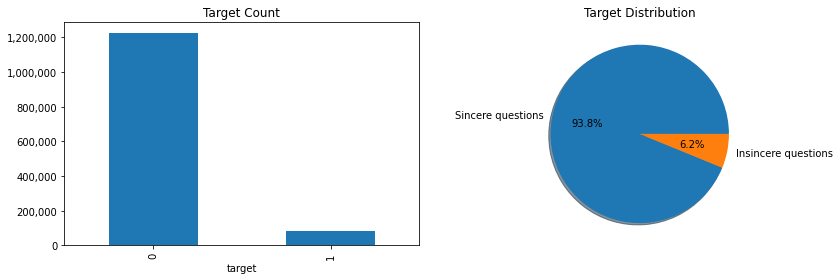

In [12]:
# Bar chart
plt.subplot(1, 2, 1)
ax = df_train.groupby('target')['qid'].count().plot.bar()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Target Count')
plt.subplots_adjust(right=1.9)

# Pie Chart
plt.subplot(1, 2, 2)
values = [df_train[df_train['target']==0].shape[0], df_train[df_train['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Target Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

__Observations:__  
- Data is highly imbalanced with only 6.2% of insincere questions.

- F1-Score seems to be right choice than accuracy here because of data imbalance.

<a id='wordcloud'></a>
####  Word cloud for both sincere and insincere questions

In [13]:
def display_wordcloud(data, title):
    words_list = data.unique().tolist()
    words = ' '.join(words_list)
    
    wordcloud = WordCloud(width = 800, height = 400,
                      stopwords = set(STOPWORDS)).generate(words)

    plt.figure(figsize=(20, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(f'Words in {title}')
    plt.axis("off")
    plt.show()

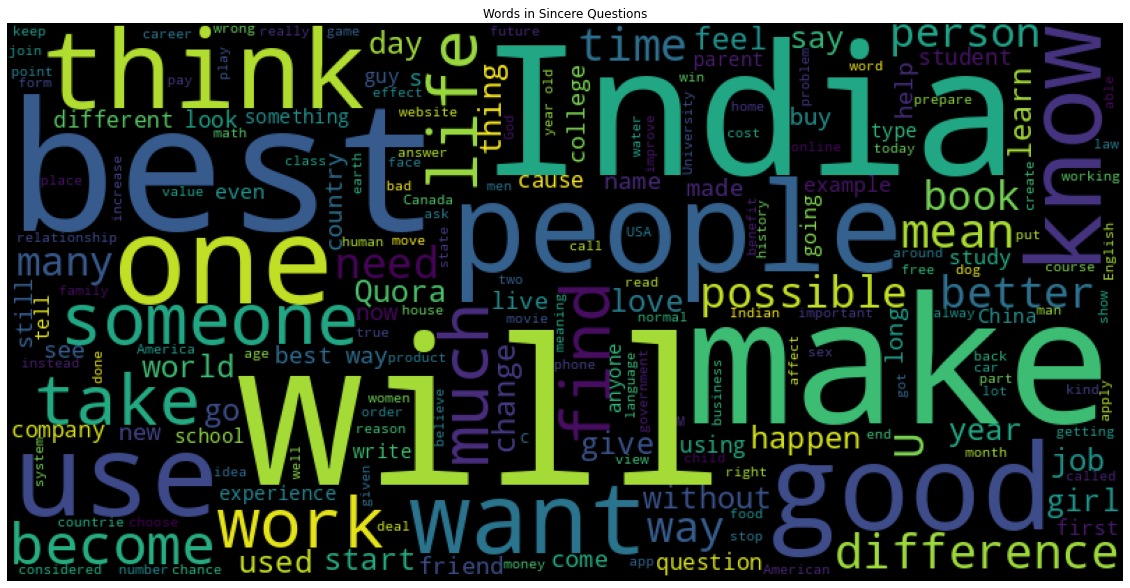

In [14]:
# Wordcloud for Sincere Questions
display_wordcloud(df_train[df_train['target']==0]['question_text'], 'Sincere Questions')

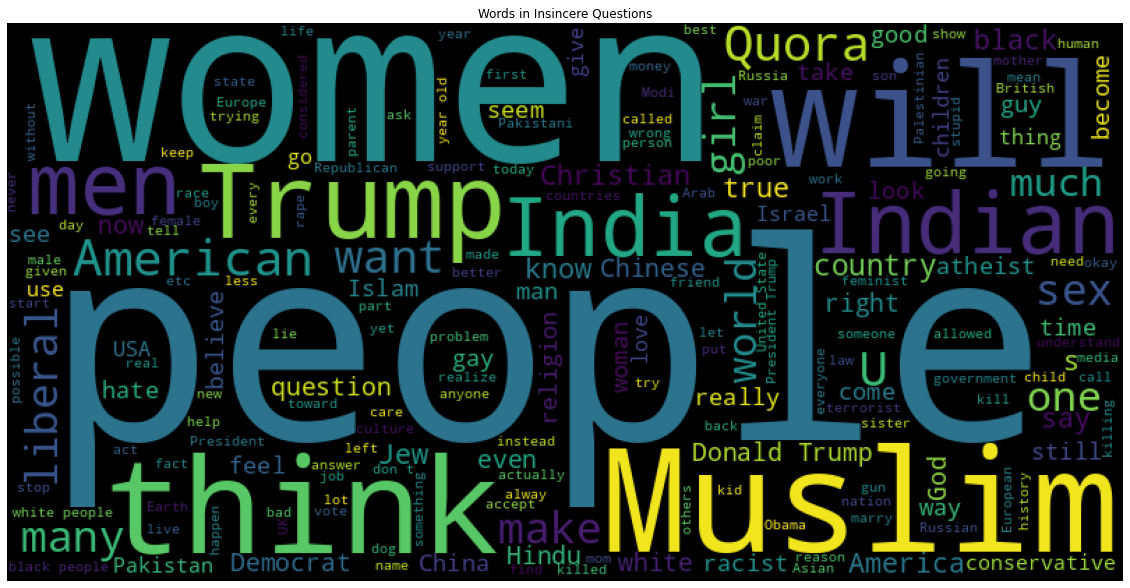

In [15]:
# Wordcloud for Insincere Questions
display_wordcloud(df_train[df_train['target']==1]['question_text'], 'Insincere Questions')

__Observations:__
- As we can see insincere questions contain many of the offensive words.
- Most of the questions are related to *People*, *Muslim*,  *Women*, *India*, *Trump*, etc.

<a id='gramstopwords'></a>
#### Top words in both sincere and insincere questions (Unigrams|Bigrams|Trigrams)

<a id='featureextraction1'></a>
#### Basic Feauture Extraction(before cleaning)

Let's construct few basic features like:
 - ____num_words____ = Number of words in question
 - ____num_capital_let____ = Number of capital letters in the question
 - ____num_special_char____ = Number of special characters in the question 
 - ____num_unique_words____ = Number of unique words in the question
 - ____num_numerics____ = Number of numerics in the question
 - ____num_char____ = Number of characters in Question
 - ____num_stopwords____ = Number of stopwords in the question

In [16]:
# https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

# Number of words
df_train['num_words'] = df_train['question_text'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['question_text'].apply(lambda x: len(str(x).split()))

# Number of capital_letters
df_train['num_capital_let'] = df_train['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
df_test['num_capital_let'] = df_test['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))

# Number of special characters
df_train['num_special_char'] = df_train['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
df_test['num_special_char'] = df_test['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()

# Number of unique words
df_train['num_unique_words'] = df_train['question_text'].apply(lambda x: len(set(str(x).split())))
df_test['num_unique_words'] = df_test['question_text'].apply(lambda x: len(set(str(x).split())))

# Number of numerics
df_train['num_numerics'] = df_train['question_text'].apply(lambda x: sum(c.isdigit() for c in x))
df_test['num_numerics'] = df_test['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

# Number of characters
df_train['num_char'] = df_train['question_text'].apply(lambda x: len(str(x)))
df_test['num_char'] = df_test['question_text'].apply(lambda x: len(str(x)))

# Number of stopwords
df_train['num_stopwords'] = df_train['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
df_test['num_stopwords'] = df_test['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))

df_train.head()

,qid,question_text,target,num_words,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char,num_stopwords
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72,7
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81,10
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67,3
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57,3
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77,7


In [17]:
#saveData(df_train,'df_without_preprocessing_train',current_path)

In [18]:
#saveData(df_test,'df_without_preprocessing_test',current_path)

<a id='featureextractionanalysis'></a>
#### Analysis on extracted features.

In [19]:
print("Minimum length of a question:", min(df_train['num_words']))
print("Maximum length of a question:", max(df_train['num_words']))
print ("Number of Questions with minimum length:", df_train[df_train['num_words']== 1].shape[0])

Minimum length of a question: 1
Maximum length of a question: 134
Number of Questions with minimum length: 24


In [20]:
def display_boxplot(_x, _y, _data, _title):
    sns.boxplot(x=_x, y=_y, data=_data)
    plt.grid(True)
    plt.title(_title)

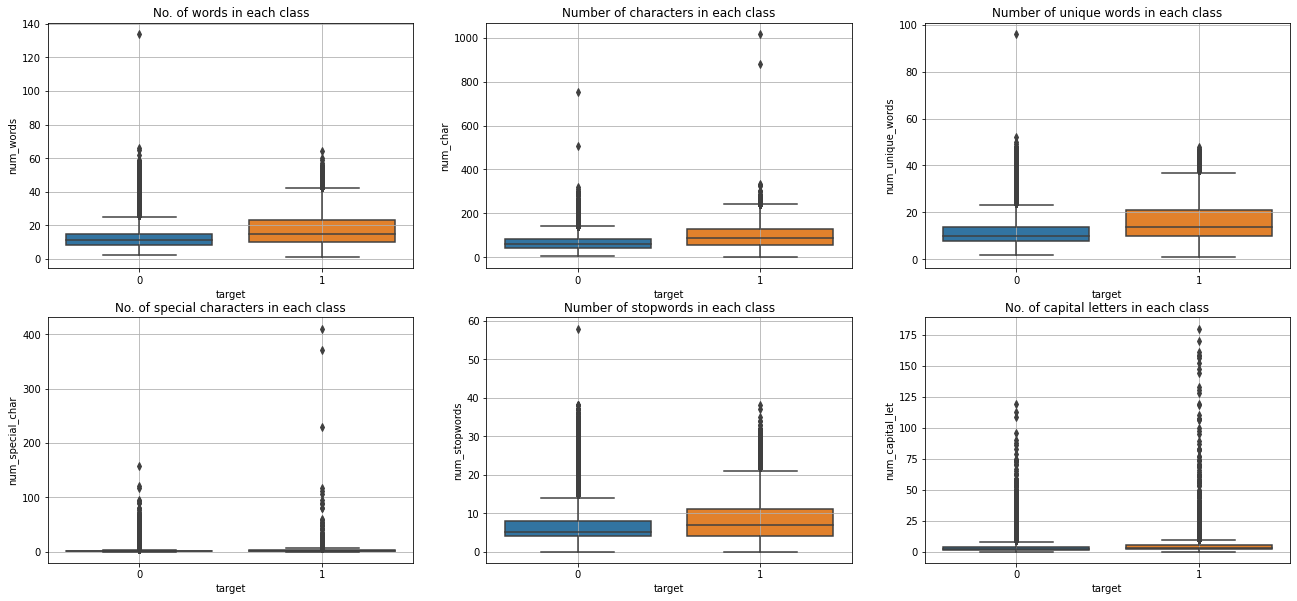

In [21]:
# Boxplot: Number of words
plt.subplot(2, 3, 1)
display_boxplot('target', 'num_words', df_train, 'No. of words in each class')

# Boxplot: Number of chars
plt.subplot(2, 3, 2)
display_boxplot('target', 'num_char', df_train, 'Number of characters in each class')

# Boxplot: Number of unique words
plt.subplot(2, 3, 3)
display_boxplot('target', 'num_unique_words', df_train, 'Number of unique words in each class')

# Boxplot: Number of special characters
plt.subplot(2, 3, 4)
display_boxplot('target', 'num_special_char', df_train, 'No. of special characters in each class')

# Boxplot: Number of stopwords
plt.subplot(2, 3, 5)
display_boxplot('target', 'num_stopwords', df_train, 'Number of stopwords in each class')

# Boxplot: Number of capital letters
plt.subplot(2, 3, 6)
display_boxplot('target', 'num_capital_let', df_train, 'No. of capital letters in each class')


plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

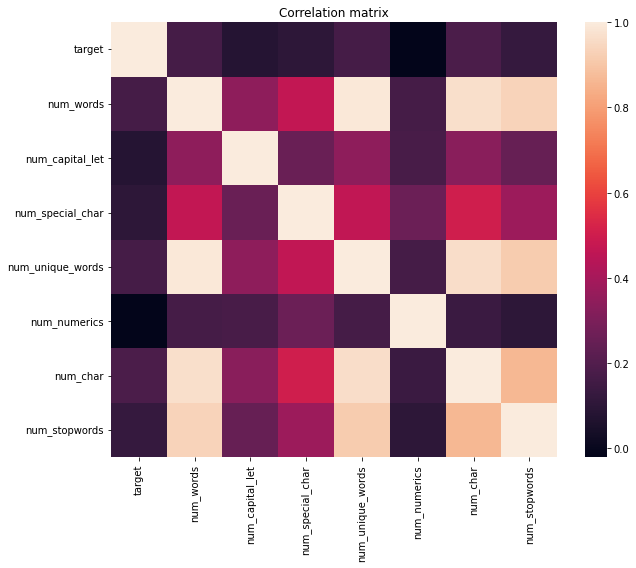

In [22]:
# Correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = df_train.corr()
sns.heatmap(corr, ax=ax)
plt.title("Correlation matrix")
plt.show()

__Observations__
- Insincere questions seems to have more words and characters.
- Insincere questions also have more unique words compare to sincere questions.

In [23]:
# Top 15 Questions with most number of non-alphanumeric characters.
  # Insincere questions are printed in red color.

qids = df_train.sort_values('num_special_char', ascending=False)['qid'].head(15).values
for id in qids:
    row = df_train[df_train['qid'].values == id]
    if row['target'].values[0] == 1: 
        color = '\033[31m'
    else:
        color = '\033[0m'
    print(color, row['question_text'].values[0], '\n')

 What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\m

In [24]:
def get_all_symbols(data):
    """
    Returns SET: special symbols in corpus
    """
    symbols=[]
    
    for text in data:
        s = re.findall(r'\W+', str(text))
        symbols.extend(s)
    return set(symbols)

In [25]:
extracted_symbols = get_all_symbols(df_train['question_text'].values)
print(extracted_symbols)

{'{(-', '” (', ' "|".', ']. ', " '?", ')) + ', '`>', '़/', '}}}}{\\', "?'", '＝ ', '}}} {', "?' (", "''?", '} ^ {-\\', '^ {', '..', '? & ', ' ^−', ']$\\', ' :) :) ', " '/", ': `', '})', ' − ', '" \\', '+ $?', '∛', ' ℅ ', '? \xa0', '!’ ', '^(√', ' \\ {-', '"..', ')] = ', '"}) ', '} , ', ' +', '}{|', '() %', ')! } {(', ' *" ', ' = [] ', '\\}, ', '₹?', '” [', "' ''", ')}{\\', ':)', '/#', 'ा-', '€-', '’ "', ' \\\\ ', 'ं"? ', ' + -', '\ue01b', '}) - (-', ' ⊥ ', '°=?', '\u200b! ', '×+', ' ، ', '$-', '} = {', ' (#) ', '%(', '[ ', ').[/', ' #$! & ', '? :/?', ') ,', ' . ..', 'ि"? ', '}? ', '@#! ', '̤', '/ [', '! :-', '} < ', '़े ', '})^', '}) + \\', '”？?', '++]));" ', '.?)?', ')} {', '{"', '? :(?', ' \\| ', "!'?", '^{\\', '|+ |', ' . ', ' £?', '-” ', '"=> ', '$ (', ') \u200b', ' │(', '))) ^', '-," "', '+,', '|/', ' $?', '-√ (', '}}\\, ', 'ै', '..." ', ')+\\', ' ! (', ')’ ', '*****” ', '#]]]]]]]]]]]]]]]]]]]]]]]]? ', '^* [/', ' () ', ': "', '^{-\\', 'ْ', '→∞', ' "… ', ' "?', '\' ("', ' (^', '\xa0?

__Observations:__
- Looks like there are some math questions(most of them are classified as insincere) in the data which contains more special chars and numbers.
- Some questions also contains emojis and non-english characters.

> <a id='ml'></a>
# Machine Learning

In [26]:
current_path ='/kaggle/input/quora-insincere-questions-classification/'
current_embedding_path = '/kaggle/working/'

df_train = pd.read_csv(current_path+'train.csv')
df_test = pd.read_csv(current_path+'test.csv')


In [27]:
#saveData(df_train,'train_df',current_embedding_path);

> <a id='datapre'></a>
## Data Preprocessing

The data is quite messy, there are lots of words that are mispelled, and some special symbols, which can not got corresponding embeddings, so before put into model, we need to clean those mispelled words and clean out the special symbols. Also, those mispelled words and special symbols could have some information, e.g., questions have mispelled words or special symbols would be more possible to be an insincere question, so I also marked them during cleaning up process.

There are two meaningful rules in preprocessing when building deep learning NLP models:
1. *Don't use standard preprocessing steps like stemming or stopword removal when you have pre-trained embeddings*
2. *Get your vocabulary as close to the embeddings as possible*

In [28]:
#Code Reference: 
#https://www.kaggle.com/code/oysiyl/107-place-solution-using-public-kernel/notebook
#https://www.kaggle.com/canming/ensemble-mean-iii-64-36
#https://www.kaggle.com/code/oysiyl/107-place-solution-using-public-kernel/notebook
#https://www.kaggle.com/code/christofhenkel/how-to-preprocessing-when-using-embeddings/notebook
#https://www.kaggle.com/code/theoviel/improve-your-score-with-some-text-preprocessing/notebook
#https://www.kaggle.com/code/theoviel/improve-your-score-with-text-preprocessing-v2/notebook

- [Replacing math equations with common abbrevation.](#rm)
- [Removing punctuations](#cleanpunt).
- [Cleaning contractions.](#cleancontra)
- [Spell Correction.](#spellclean)
- [Removing Numbers(not use).](#cleannumber)
- [Feature extraction II.](#addfeature)
- [Data Cleaning.](#cleaning)

> <a id='rm'></a>

In [29]:
# Replacing math equations and url addresses with tags.
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36

def clean_tag(x):
    if '[math]' in x:
        x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    #if 'http' in x or 'www' in x:
    #    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
    return x

> <a id='cleanpunt'></a>

In [30]:
# clean_punct
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

# Use punctuation to split 
def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

> <a id='cleancontra'></a>

In [31]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", 
#                  "€": "e","£": "e",
                 "™": " tm ", "√": " sqrt ", "×": "x", "²": "2",
                 "—": "-", "–": "-", "’": "'",
                 "_": "-", "`": "'", '“': '"',
                 '”': '"', '“': '"',  '∞':
                 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha',
                 '•': '.', 'à': 'a', '−': '-', 'β': 'beta',
                 '∅': '', '³': '3', 'π': 'pi',"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                 "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                 '…': ' ... ', '\ufeff': '', "’":"'", "‘":"'", "´":"'", "`":"'"}


contraction_mapping = {" ain't": " is not", " aren't": " are not"," can't": " cannot",
                       " cause": " because", " could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not",
                       "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is",
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                       "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                       "she's": "she is", "should've": "should have", "shouldn't": "should not",
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have",
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have",
                       "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                       "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will",
                       "what'll've": "what will have", "what're": "what are",  "what's": "what is",
                       "what've": "what have", "when's": "when is", "when've": "when have",
                       "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                       "y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are",
                       "you've": "you have" }

mapping = {**contraction_mapping,**punct_mapping}

# Substitute contraction
def clean_contractions(text, mapping=mapping):
    for error in mapping:
        if error in text:
            text = text.replace(error, mapping[error])
#     text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #if i want to remove it too
    return text


> <a id='spellclean'></a>

In [32]:
mispell_dict1 = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite',
                'travelling': 'traveling', 'counselling': 'counseling',
                'theatre': 'theater', 'cancelled': 'canceled', ' labour ': ' labor ',
                'organisation': 'organization', 'wwii': 'world war 2',
                'citicise': 'criticize', ' youtu  ': ' youtube ', ' qoura ': ' quora ',
                'sallary': 'salary', 'whta': 'what', 'narcisist': 'narcissist',
                'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do',
                ' doi ': ' do I ', 'thebest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate',
                "mastrubating": 'masturbating', 'pennis': 'penis', 'etherium': 'ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': 'nba game',
                '2k18': 'nba game', 'qouta': 'quota', 'upwork': 'up work', 'loy machedo' :' branding coach',
                'loy machedo' :' branding coach', 'gdpr' : 'general data protection regulation',
                'adityanath' : 'indian politician', 'adhaar' : 'aadhaar',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp',
                'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization', 'pokémon': 'pokemon', 'quorans': 'quora',
                'brexit': 'britich exit', 'cryptocurrencies': 'crypto currencies', 'redmi': 'chinese cellphone',
                'coinbase': 'coin base', 'oneplus': 'chinese cellphone', 'uceed': 'toefl', 'bhakts': 'bhakt',
                'bhakts' : 'bhakt', 'f***' : 'fuck', 'f**k' : 'fuck', 'f**cked' : 'fucked', 'f*#k' : 'fuck',
                'f**krs*' : 'fuckers', 'f*cking' : 'fucking', 'f**king' : 'fucking',
                'boruto' : 'naruto', 'alshamsi' : 'al shamsi', 'fiancé' : 'fiance',
                'dceu' : 'dc extended universe', 'iiest' : 'iit', 'srmjee' : 'joint entrance exam',
                'litecoin' : 'bitcoin', 'unacademy' : 'un academy', 'sjws' : 'social justice warriors',
                'tensorflow' : 'tensor flow', 'lnmiit' : 'iit', 'kavalireddi' : 'analyst',
                'doklam' : 'border between china and india', 'altcoin' : 'bitcoin', 
                'muoet' : 'manipal university online entrance exam', 'vajiram' : 'indian coaching center',
                'nicmar' : 'national institute of construction management and research', 
                'bnbr' : 'be nice be respectful', " e g ": " eg ", " b g ": " bg ", " u s ": " america ", 
                " 9 11 ": " 911 ", "e - mail": "email", " j k ": " jk "}

mispell_dict2={'jewprofits': 'jew profits', 'qmas': 'quality migrant admission scheme', 'casterating': 'castrating', 'kashmiristan': 'kashmir', 'careongo': 'india first and largest online distributor of medicines', 'setya novanto': 'a former indonesian politician', 'testoultra': 'male sexual enhancement supplement', 'rammayana': 'ramayana', 'badaganadu': 'brahmin community that mainly reside in karnataka', 'bitcjes': 'bitches', 'mastubrate': 'masturbate', 'français': 'france', 'adsresses': 'address', 'flemmings': 'flemming', 'intermate': 'inter mating', 'feminisam': 'feminism', 'cuckholdry': 'cuckold', 'niggor': 'black hip-hop and electronic artist', 'narcsissist': 'narcissist', 'genderfluid': 'gender fluid', ' im ': ' i am ', ' dont ': ' do not ', 'qoura': 'quora', 'ethethnicitesnicites': 'ethnicity', 'namit bathla': 'content writer', 'what sapp': 'whatsapp', 'führer': 'fuhrer', 'covfefe': 'coverage', 'accedentitly': 'accidentally', 'cuckerberg': 'zuckerberg', 'transtrenders': 'incredibly disrespectful to real transgender people', 'frozen tamod': 'pornographic website', 'hindians': 'north indian', 'hindian': 'north indian', 'celibatess': 'celibates', 'trimp': 'trump', 'wanket': 'wanker', 'wouldd': 'would', 'arragent': 'arrogant', 'ra - apist': 'rapist', 'idoot': 'idiot', 'gangstalkers': 'gangs talkers', 'toastsexual': 'toast sexual', 'inapropriately': 'inappropriately', 'dumbassess': 'dumbass', 'germanized': 'become german', 'helisexual': 'sexual', 'regilious': 'religious', 'timetraveller': 'time traveller', 'darkwebcrawler': 'dark webcrawler', 'routez': 'route', 'trumpians': 'trump supporters', 'irreputable': 'reputation', 'serieusly': 'seriously', 'anti cipation': 'anticipation', 'microaggression': 'micro aggression', 'afircans': 'africans', 'microapologize': 'micro apologize', 'vishnus': 'vishnu', 'excritment': 'excitement', 'disagreemen': 'disagreement', 'gujratis': 'gujarati', 'gujaratis': 'gujarati', 'ugggggggllly': 'ugly', 'germanity': 'german', 'soyboys': 'cuck men lacking masculine characteristics', 'н': 'h', 'м': 'm', 'ѕ': 's', 'т': 't', 'в': 'b', 'υ': 'u', 'ι': 'i', 'genetilia': 'genitalia', 'r - apist': 'rapist', 'borokabama': 'barack obama', 'arectifier': 'rectifier', 'pettypotus': 'petty potus', 'magibabble': 'magi babble', 'nothinking': 'thinking', 'centimiters': 'centimeters', 'saffronized': 'india, politics, derogatory', 'saffronize': 'india, politics, derogatory', ' incect ': ' insect ', 'weenus': 'elbow skin', 'pakistainies': 'pakistanis', 'goodspeaks': 'good speaks', 'inpregnated': 'in pregnant', 'rapefilms': 'rape films', 'rapiest': 'rapist', 'hatrednesss': 'hatred', 'heightism': 'height discrimination', 'getmy': 'get my', 'onsocial': 'on social', 'worstplatform': 'worst platform', 'platfrom': 'platform', 'instagate': 'instigate', 'loy machedeo': 'person', ' dsire ': ' desire ', 'iservant': 'servant', 'intelliegent': 'intelligent', 'ww 1': ' ww1 ', 'ww 2': ' ww2 ', 'keralapeoples': 'kerala peoples', 'trumpervotes': 'trumper votes', 'fucktrumpet': 'fuck trumpet', 'likebjaish': 'like bjaish', 'likemy': 'like my', 'howlikely': 'how likely', 'disagreementts': 'disagreements', 'disagreementt': 'disagreement', 'meninist': 'male chauvinism', 'feminists': 'feminism supporters', 'ghumendra': 'bhupendra', 'emellishments': 'embellishments', 'settelemen': 'settlement', 'richmencupid': 'rich men dating website', 'gaudry - schost': '', 'ladymen': 'ladyboy', 'hasserment': 'harassment', 'instrumentalizing': 'instrument', 'darskin': 'dark skin', 'balckwemen': 'balck women', 'recommendor': 'recommender', 'wowmen': 'women', 'expertthink': 'expert think', 'whitesplaining': 'white splaining', 'inquoraing': 'inquiring', 'whilemany': 'while many', 'manyother': 'many other', 'involvedinthe': 'involved in the', 'slavetrade': 'slave trade', 'aswell': 'as well', 'fewshowanyremorse': 'few show any remorse', 'trageting': 'targeting', 'getile': 'gentile', 'gujjus': 'derogatory gujarati', 'judisciously': 'judiciously', 'hue mungus': 'feminist bait', 'hugh mungus': 'feminist bait', 'hindustanis': 'hindu', 'virushka': 'great relationships couple', 'exclusinary': 'exclusionary', 'himdus': 'hindus', 'milo yianopolous': 'a british polemicist', 'hidusim': 'hinduism', 'holocaustable': 'holocaust', 'evangilitacal': 'evangelical', 'busscas': 'buscas', 'holocaustal': 'holocaust', 'incestious': 'incestuous', 'tennesseus': 'tennessee', 'gusdur': 'gus dur', 'rpatah - tan eng hwan': 'silsilah', 'reinfectus': 'reinfect', 'pharisaistic': 'pharisaism', 'nuslims': 'muslims', 'taskus': '', 'musims': 'muslims', 'musevi': 'the independence of mexico', ' racious ': 'discrimination expression of racism', 'muslimophobia': 'muslim phobia', 'justyfied': 'justified', 'holocause': 'holocaust', 'musilim': 'muslim', 'misandrous': 'misandry', 'glrous': 'glorious', 'desemated': 'decimated', 'votebanks': 'vote banks', 'parkistan': 'pakistan', 'eurooe': 'europe', 'animlaistic': 'animalistic', 'asiasoid': 'asian', 'congoid': 'congolese', 'inheritantly': 'inherently', 'asianisation': 'becoming asia', 'russosphere': 'russia sphere of influence', 'exmuslims': 'ex muslims', 'discriminatein': 'discrimination', ' hinus ': ' hindus ', 'nibirus': 'nibiru', 'habius - corpus': 'habeas corpus', 'prentious': 'pretentious', 'sussia': 'ancient jewish village', 'moustachess': 'moustaches', 'russions': 'russians', 'yuguslavia': 'yugoslavia', 'atrocitties': 'atrocities', 'muslimophobe': 'muslim phobic', 'fallicious': 'fallacious', 'recussed': 'recursed', '@ usafmonitor': 'usa monitor', 'lustfly': 'lustful', 'canmuslims': 'can muslims', 'journalust': 'journalist', 'digustingly': 'disgustingly', 'harasing': 'harassing', 'greatuncle': 'great uncle', 'drumpf': 'trump', 'rejectes': 'rejected', 'polyagamous': 'polygamous', 'mushlims': 'muslims', 'accusition': 'accusation', 'geniusses': 'geniuses', 'moustachesomething': 'moustache something', 'heineous': 'heinous', 'sapiosexuals': 'sapiosexual', 'sapiosexual': 'sexually attracted to intelligence', 'pansexuals': 'pansexual', 'autosexual': 'auto sexual', 'sexualslutty': 'sexual slutty', 'hetorosexuality': 'hetoro sexuality', 'chinesese': 'chinese', 'pizza gate': 'debunked conspiracy theory', 'countryless': 'having no country', 'muslimare': 'muslim are', 'iphonex': 'iphone', 'lionese': 'lioness', 'marionettist': 'marionettes', 'demonetize': 'demonetized', 'eneyone': 'anyone', 'karonese': 'karo people indonesia', 'minderheid': 'minder worse', 'mainstreamly': 'mainstream', 'contraproductive': 'contra productive', 'diffenky': 'differently', 'abandined': 'abandoned', 'p0 rnstars': 'pornstars', 'overproud': 'over proud', 'cheekboned': 'cheek boned', 'heriones': 'heroines', 'eventhogh': 'even though', 'americanmedicalassoc': 'american medical assoc', 'feelwhen': 'feel when', 'hhhow': 'how', 'reallysemites': 'really semites', 'gamergaye': 'gamersgate', 'manspreading': 'man spreading', 'thammana': 'tamannaah bhatia', 'dogmans': 'dogmas', 'managementskills': 'management skills', 'mangoliod': 'mongoloid', 'geerymandered': 'gerrymandered', 'mandateing': 'man dateing', 'mailwoman': 'mail woman', 'humancoalition': 'human coalition', 'manipullate': 'manipulate', 'everyo0 ne': 'everyone', 'takeove': 'takeover', 'nonchristians': 'non christians', 'goverenments': 'governments', 'govrment': 'government', 'polygomists': 'polygamists', 'demogorgan': 'demogorgon', 'maralago': 'mar-a-lago', 'antibigots': 'anti bigots', 'gouing': 'going', 'muzaffarbad': 'muzaffarabad', 'suchvstupid': 'such stupid', 'apartheidisrael': 'apartheid israel', 'personaltiles': 'personal titles', 'lawyergirlfriend': 'lawyer girl friend', 'northestern': 'northwestern', 'yeardold': 'years old', 'masskiller': 'mass killer', 'southeners': 'southerners', 'unitedstatesian': 'united states', 'peoplekind': 'people kind', 'peoplelike': 'people like', 'countrypeople': 'country people', 'shitpeople': 'shit people', 'trumpology': 'trump ology', 'trumpites': 'trump supporters', 'trumplies': 'trump lies', 'donaldtrumping': 'donald trumping', 'trumpdating': 'trump dating', 'trumpsters': 'trumpeters', 'ciswomen': 'cis women', 'womenizer': 'womanizer', 'pregnantwomen': 'pregnant women', 'autoliker': 'auto liker', 'smelllike': 'smell like', 'autolikers': 'auto likers', 'religiouslike': 'religious like', 'likemail': 'like mail', 'fislike': 'dislike', 'sneakerlike': 'sneaker like', 'like⬇': 'like', 'likelovequotes': 'like lovequotes', 'likelogo': 'like logo', 'sexlike': 'sex like', 'whatwould': 'what would', 'howwould': 'how would', 'manwould': 'man would', 'exservicemen': 'ex servicemen', 'femenism': 'feminism', 'devopment': 'development', 'doccuments': 'documents', 'supplementplatform': 'supplement platform', 'mendatory': 'mandatory', 'moviments': 'movements', 'kremenchuh': 'kremenchug', 'docuements': 'documents', 'determenism': 'determinism', 'envisionment': 'envision ment', 'tricompartmental': 'tri compartmental', 'addmovement': 'add movement', 'mentionong': 'mentioning', 'whichtreatment': 'which treatment', 'repyament': 'repayment', 'insemenated': 'inseminated', 'inverstment': 'investment', 'managemental': 'manage mental', 'inviromental': 'environmental', 'menstrution': 'menstruation', 'indtrument': 'instrument', 'mentenance': 'maintenance', 'fermentqtion': 'fermentation', 'achivenment': 'achievement', 'mismanagements': 'mis managements', 'requriment': 'requirement', 'denomenator': 'denominator', 'drparment': 'department', 'celemente': 'clemente', 'manajement': 'management', 'govermenent': 'government', 'accomplishmments': 'accomplishments', 'rendementry': 'rendement ry', 'repariments': 'departments', 'menstrute': 'menstruate', 'determenistic': 'deterministic', 'resigment': 'resignment', 'selfpayment': 'self payment', 'imrpovement': 'improvement', 'enivironment': 'environment', 'compartmentley': 'compartment', 'augumented': 'augmented', 'parmenent': 'permanent', 'develepoments': 'developments', 'menstrated': 'menstruated', 'phnomenon': 'phenomenon', 'employmment': 'employment', 'menigioma': 'meningioma', 'recrument': 'recrement', 'promenient': 'provenient', 'gonverment': 'government', 'statemment': 'statement', 'recuirement': 'requirement', 'invetsment': 'investment', 'parilment': 'parchment', 'parmently': 'patiently', 'agreementindia': 'agreement india', 'menifesto': 'manifesto', 'accomplsihments': 'accomplishments', 'disangagement': 'disengagement', 'aevelopment': 'development', 'procument': 'procumbent', 'harashment': 'harassment', 'tiannanmen': 'tiananmen', 'commensalisms': 'commensal isms', 'devlelpment': 'development', 'dimensons': 'dimensions', 'recruitment2017': 'recruitment 2017', 'polishment': 'pol ishment', 'commentsafe': 'comment safe', 'meausrements': 'measurements', 'geomentrical': 'geometrical', 'undervelopment': 'undevelopment', 'mensurational': 'mensuration al', 'fanmenow': 'fan menow', 'permenganate': 'permanganate', 'bussinessmen': 'businessmen', 'supertournaments': 'super tournaments', 'permanmently': 'permanently', 'lamenectomy': 'lamnectomy', 'assignmentcanyon': 'assignment canyon', 'adgestment': 'adjustment', 'mentalized': 'metalized', 'docyments': 'documents', 'requairment': 'requirement', 'batsmencould': 'batsmen could', 'argumentetc': 'argument etc', 'enjoiment': 'enjoyment', 'invement': 'movement', 'accompliushments': 'accomplishments', 'regements': 'regiments', 'departmenthow': 'department how', 'aremenian': 'armenian', 'amenclinics': 'amen clinics', 'nonfermented': 'non fermented', 'instumentation': 'instrumentation', 'mentalitiy': 'mentality', ' govermen ': 'goverment', 'underdevelopement': 'under developement', 'parlimentry': 'parliamentary', 'indemenity': 'indemnity', 'inatrumentation': 'instrumentation', 'menedatory': 'mandatory', 'mentiri': 'entire', 'accomploshments': 'accomplishments', 'instrumention': 'instrumentation', 'afvertisements': 'advertisements', 'entitlments': 'entitlements', 'endrosment': 'endorsement', 'improment': 'impriment', 'archaemenid': 'achaemenid', 'replecement': 'replacement', 'placdment': 'placement', 'femenise': 'feminise', 'envinment': 'environment', 'amenitycompany': 'amenity company', 'increaments': 'increments', 'accomplihsments': 'accomplishments', 'manygovernment': 'many government', 'panishments': 'punishments', 'elinment': 'eloinment', 'mendalin': 'mend alin', 'farmention': 'farm ention', 'preincrement': 'pre increment', 'postincrement': 'post increment', 'achviements': 'achievements', 'menditory': 'mandatory', 'emouluments': 'emoluments', 'stonemen': 'stone men', 'menmium': 'medium', 'entaglement': 'entanglement', 'integumen': 'integument', 'harassument': 'harassment', 'retairment': 'retainment', 'enviorement': 'environment', 'tormentous': 'torment ous', 'confiment': 'confident', 'enchroachment': 'encroachment', 'prelimenary': 'preliminary', 'fudamental': 'fundamental', 'instrumenot': 'instrument', 'icrement': 'increment', 'prodimently': 'prominently', 'meniss': 'menise', 'whoimplemented': 'who implemented', 'representment': 'rep resentment', 'startfragment': 'start fragment', 'endfragment': 'end fragment', ' documentarie ': ' documentaries ', 'requriments': 'requirements', 'constitutionaldevelopment': 'constitutional development', 'parlamentarians': 'parliamentarians', 'rumenova': 'rumen ova', 'argruments': 'arguments', 'findamental': 'fundamental', 'totalinvestment': 'total investment', 'gevernment': 'government', 'recmommend': 'recommend', 'appsmoment': 'apps moment', 'menstruual': 'menstrual', 'immplemented': 'implemented', 'engangement': 'engagement', 'invovement': 'involvement', 'returement': 'retirement', 'simentaneously': 'simultaneously', 'accompishments': 'accomplishments', 'menstraution': 'menstruation', 'experimently': 'experiment', 'abdimen': 'abdomen', 'cemenet': 'cement', 'propelment': 'propel ment', 'unamendable': 'un amendable', 'employmentnews': 'employment news', 'lawforcement': 'law forcement', 'menstuating': 'menstruating', 'fevelopment': 'development', 'reglamented': 'reg lamented', 'imrovment': 'improvement', 'recommening': 'recommending', 'sppliment': 'supplement', 'measument': 'measurement', 'reimbrusement': 'reimbursement', 'nutrament': 'nutriment', 'puniahment': 'punishment', 'subligamentous': 'sub ligamentous', 'comlementry': 'complementary', 'reteirement': 'retirement', 'envioronments': 'environments', 'haraasment': 'harassment', 'usagovernment': 'usa government', 'apartmentfinder': 'apartment finder', 'encironment': 'environment', 'metacompartment': 'meta compartment', 'augumentation': 'argumentation', 'dsymenorrhoea': 'dysmenorrhoea', 'nonabandonment': 'non abandonment', 'annoincement': 'announcement', 'menberships': 'memberships', 'gamenights': 'game nights', 'enliightenment': 'enlightenment', 'supplymentry': 'supplementary', 'parlamentary': 'parliamentary', 'duramen': 'dura men', 'hotelmanagement': 'hotel management', 'deartment': 'department', 'treatmentshelp': 'treatments help', 'attirements': 'attire ments', 'amendmending': 'amend mending', 'pseudomeningocele': 'pseudo meningocele', 'intrasegmental': 'intra segmental', 'treatmenent': 'treatment', 'infridgement': 'infringement', 'infringiment': 'infringement', 'recrecommend': 'rec recommend', 'entartaiment': 'entertainment', 'inplementing': 'implementing', 'indemendent': 'independent', 'tremendeous': 'tremendous', 'commencial': 'commercial', 'scomplishments': 'accomplishments', 'emplement': 'implement', 'dimensiondimensions': 'dimension dimensions', 'depolyment': 'deployment', 'conpartment': 'compartment', 'govnments': 'movements', 'menstrat': 'menstruate', 'accompplishments': 'accomplishments', 'enchacement': 'enchancement', 'developmenent': 'development', 'emmenagogues': 'emmenagogue', 'aggeement': 'agreement', 'elementsbond': 'elements bond', 'remenant': 'remnant', 'manamement': 'management', 'dimensonless': 'dimensionless', 'ointmentsointments': 'ointments ointments', 'achiements': 'achievements', 'recurtment': 'recurrent', 'gouverments': 'governments', 'docoment': 'document', 'programmingassignments': 'programming assignments', 'menifest': 'manifest', 'investmentguru': 'investment guru', 'deployements': 'deployments', 'plaement': 'placement', 'perliament': 'parliament', 'femenists': 'feminists', 'ecumencial': 'ecumenical', 'advamcements': 'advancements', 'refundment': 'refund ment', 'settlementtake': 'settlement take', 'mensrooms': 'mens rooms', 'productmanagement': 'product management', 'armenains': 'armenians', 'betweenmanagement': 'between management', 'difigurement': 'disfigurement', 'armenized': 'armenize', 'hurrasement': 'hurra sement', 'mamgement': 'management', 'momuments': 'monuments', 'eauipments': 'equipments', 'managemenet': 'management', 'treetment': 'treatment', 'webdevelopement': 'web developement', 'supplemenary': 'supplementary', 'encironmental': 'environmental', 'understandment': 'understand ment', 'enrollnment': 'enrollment', 'thinkstrategic': 'think strategic', 'thinkinh': 'thinking', 'softthinks': 'soft thinks', 'underthinking': 'under thinking', 'thinksurvey': 'think survey', 'whitelash': 'white lash', 'whiteheds': 'whiteheads', 'whitetning': 'whitening', 'whitegirls': 'white girls', 'whitewalkers': 'white walkers', 'manycountries': 'many countries', 'accomany': 'accompany', 'fromgermany': 'from germany', 'manychat': 'many chat', 'germanyl': 'germany', 'manyness': 'many ness', 'many4': 'many', 'digitizeindia': 'digitize india', 'indiarush': 'india rush', 'indiareads': 'india reads', 'telegraphindia': 'telegraph india', 'southindia': 'south india', 'airindia': 'air india', 'siliconindia': 'silicon india', 'indianleaders': 'indian leaders', 'fundsindia': 'funds india', 'indianarmy': 'indian army', 'technoindia': 'techno india', 'betterindia': 'better india', 'capesindia': 'capes india', 'rigetti': 'ligetti', 'vegetablr': 'vegetable', 'get90': 'get', 'magetta': 'maretta', 'nagetive': 'native', 'isunforgettable': 'is unforgettable', 'get630': 'get 630', 'gadgetpack': 'gadget pack', 'languagetool': 'language tool', 'bugdget': 'budget', 'africaget': 'africa get', 'abnegetive': 'abnegative', 'orangetheory': 'orange theory', 'getsmuggled': 'get smuggled', 'avegeta': 'ave geta', 'gettubg': 'getting', 'gadgetsnow': 'gadgets now', 'surgetank': 'surge tank', 'gadagets': 'gadgets', 'getallparts': 'get allparts', 'messenget': 'messenger', 'vegetarean': 'vegetarian', 'get1000': 'get 1000', 'getfinancing': 'get financing', 'getdrip': 'get drip', 'adstargets': 'ads targets', 'tgethr': 'together', 'vegetaries': 'vegetables', 'forgetfulnes': 'forgetfulness', 'fisgeting': 'fidgeting', 'budgetair': 'budget air', 'getdepersonalization': 'get depersonalization', 'negetively': 'negatively', 'gettibg': 'getting', 'nauget': 'naught', 'bugetti': 'bugatti', 'plagetum': 'plage tum', 'vegetabale': 'vegetable', 'changetip': 'change tip', 'blackwashing': 'black washing', 'blackpink': 'black pink', 'blackmoney': 'black money', 'blackmarks': 'black marks', 'blackbeauty': 'black beauty', 'unblacklisted': 'un blacklisted', 'blackdotes': 'black dotes', 'blackboxing': 'black boxing', 'blackpaper': 'black paper', 'blackpower': 'black power', 'latinamericans': 'latin americans', 'musigma': 'mu sigma', 'usict': 'ussct', 'indominus': 'in dominus', 'plus5': 'plus', 'russiagate': 'russia gate', 'russophobic': 'russophobiac', 'radijus': 'radius', 'cobustion': 'combustion', 'austrialians': 'australians', 'mylogenous': 'myogenous', 'raddus': 'radius', 'hetrogenous': 'heterogenous', 'greenhouseeffect': 'greenhouse effect', 'aquous': 'aqueous', 'taharrush': 'tahar rush', 'senousa': 'venous', 'cityairbus': 'city airbus', 'sponteneously': 'spontaneously', 'trustless': 't rustless', 'fusanosuke': 'fu sanosuke', 'isthmuses': 'isthmus es', 'lucideus': 'lucidum', 'overjustification': 'over justification', 'bindusar': 'bind usar', 'cousera': 'online education platform', 'musturbation': 'masturbation', 'infustry': 'industry', 'huswifery': 'a poem', 'rombous': 'bombous', 'disengenuously': 'disingenuously', 'sllybus': 'syllabus', 'celcious': 'delicious', 'cellsius': 'celsius', 'lethocerus': 'lethocerus', 'monogmous': 'monogamous', 'ballyrumpus': 'bally rumpus', 'koushika': 'koushika', 'vivipoarous': 'viviparous', 'ludiculous': 'ridiculous', 'sychronous': 'synchronous', 'industiry': 'industry', 'scuduse': 'scud use', 'babymust': 'baby must', 'simultqneously': 'simultaneously', 'exust': 'ex ust', 'notmusing': 'not musing', 'zamusu': 'amuse', 'tusaki': 'tu saki', 'marrakush': 'marrakesh', 'justcheaptickets': 'just cheaptickets', 'ayahusca': 'ayahausca', 'samousa': 'samosa', 'gusenberg': 'gutenberg', 'illustratuons': 'illustrations', 'extemporeneous': 'extemporaneous', 'mathusla': 'mathusala', 'confundus': 'con fundus', 'tusts': 'trusts', 'poisenious': 'poisonous', 'mevius': 'medius', 'inuslating': 'insulating', 'aroused21000': 'aroused 21000', 'wenzeslaus': 'wenceslaus', 'justinkase': 'justin kase', 'purushottampur': 'purushottam pur', 'citruspay': 'citrus pay', 'secutus': 'sects', 'austentic': 'austenitic', 'faceplusplus': 'face plusplus', 'aysnchronous': 'asynchronous', 'teamtreehouse': 'team treehouse', 'uncouncious': 'unconscious', 'priebuss': 'prie buss', 'consciousuness': 'consciousness', 'susubsoil': 'su subsoil', 'trimegistus': 'trismegistus', 'protopeterous': 'protopterous', 'trustworhty': 'trustworthy', 'ushually': 'usually', 'industris': 'industries', 'instantneous': 'instantaneous', 'superplus': 'super plus', 'shrusti': 'shruti', 'hindhus': 'hindus', 'outonomous': 'autonomous', 'reliegious': 'religious', 'kousakis': 'kou sakis', 'reusult': 'result', 'janusgraph': 'janus graph', 'palusami': 'palus ami', 'mussraff': 'muss raff', 'hukous': 'humous', 'photoacoustics': 'photo acoustics', 'kushanas': 'kusha nas', 'justdile': 'justice', 'massahusetts': 'massachusetts', 'uspset': 'upset', 'sustinet': 'sustinent', 'consicious': 'conscious', 'sadhgurus': 'sadh gurus', 'hystericus': 'hysteric us', 'visahouse': 'visa house', 'supersynchronous': 'super synchronous', 'posinous': 'rosinous', 'fernbus': 'fern bus', 'tiltbrush': 'tilt brush', 'glueteus': 'gluteus', 'posionus': 'poisons', 'freus': 'frees', 'zhuchengtyrannus': 'zhucheng tyrannus', 'savonious': 'sanious', 'cusjo': 'cusco', 'congusion': 'confusion', 'dejavus': 'dejavu s', 'uncosious': 'uncopious', 'previius': 'previous', 'counciousness': 'conciousness', 'lustorus': 'lustrous', 'sllyabus': 'syllabus', 'mousquitoes': 'mosquitoes', 'savvius': 'savvies', 'arceius': 'arcesius', 'prejusticed': 'prejudiced', 'requsitioned': 'requisitioned', 'deindustralization': 'deindustrialization', 'muscleblaze': 'muscle blaze', 'consciousx5': 'conscious', 'nitrogenious': 'nitrogenous', 'mauritious': 'mauritius', 'rigrously': 'rigorously', 'yutyrannus': 'yu tyrannus', 'muscualr': 'muscular', 'conscoiusness': 'consciousness', 'causians': 'crusians', 'workfusion': 'work fusion', 'puspak': 'pu spak', 'inspirus': 'inspires', 'illiustrations': 'illustrations', 'nobushi': 'no bushi', 'theuseof': 'thereof', 'suspicius': 'suspicious', 'intuous': 'virtuous', 'gaushalas': 'gaus halas', 'campusthrough': 'campus through', 'seriousity': 'seriosity', 'resustence': 'resistence', 'geminatus': 'geminates', 'disquss': 'discuss', 'nicholus': 'nicholas', 'husnai': 'hussar', 'diiscuss': 'discuss', 'diffussion': 'diffusion', 'phusicist': 'physicist', 'ernomous': 'enormous', 'khushali': 'khushal i', 'heitus': 'leitus', 'cracksbecause': 'cracks because', 'nautlius': 'nautilus', 'trausted': 'trusted', 'dardandus': 'dardanus', 'megatapirus': 'mega tapirus', 'clusture': 'culture', 'vairamuthus': 'vairamuthu s', 'disclousre': 'disclosure', 'industrilaization': 'industrialization', 'musilms': 'muslims', 'australia9': 'australian', 'causinng': 'causing', 'ibdustries': 'industries', 'searious': 'serious', 'coolmuster': 'cool muster', 'sissyphus': 'sisyphus', ' justificatio ': 'justification', 'antihindus': 'anti hindus', 'moduslink': 'modus link', 'zymogenous': 'zymogen ous', 'prospeorus': 'prosperous', 'retrocausality': 'retro causality', 'fusiongps': 'fusion gps', 'mouseflow': 'mouse flow', 'bootyplus': 'booty plus', 'itylus': 'i tylus', 'olnhausen': 'olshausen', 'suspeect': 'suspect', 'entusiasta': 'enthusiast', 'fecetious': 'facetious', 'bussiest': 'fussiest', 'draconius': 'draconis', 'requsite': 'requisite', 'nauseatic': 'nausea tic', 'brusssels': 'brussels', 'repurcussion': 'repercussion', 'jeisus': 'jesus', 'philanderous': 'philander ous', 'muslisms': 'muslims', 'august2017': 'august 2017', 'calccalculus': 'calc calculus', 'unanonymously': 'un anonymously', 'imaprtus': 'impetus', 'carnivorus': 'carnivorous', 'corypheus': 'coryphees', 'austronauts': 'astronauts', 'neucleus': 'nucleus', 'housepoor': 'house poor', 'rescouses': 'responses', 'tagushi': 'tagus hi', 'hyperfocusing': 'hyper focusing', 'nutriteous': 'nutritious', 'chylus': 'chylous', 'preussure': 'pressure', 'outfocus': 'out focus', 'hanfus': 'hannus', 'rustyrose': 'rusty rose', 'vibhushant': 'vibhushan t', 'conciousnes': 'conciousness', 'venus25': 'venus', 'sedataious': 'seditious', 'promuslim': 'pro muslim', 'statusguru': 'status guru', 'yousician': 'musician', 'transgenus': 'trans genus', 'pushbullet': 'push bullet', 'jeesyllabus': 'jee syllabus', 'complusary': 'compulsory', 'holocoust': 'holocaust', 'careerplus': 'career plus', 'lllustrate': 'illustrate', 'musino': 'musion', 'phinneus': 'phineus', 'usedtoo': 'used too', 'justbasic': 'just basic', 'webmusic': 'web music', 'trustkit': 'trust kit', 'industrzgies': 'industries', 'rubustness': 'robustness', 'missuses': 'miss uses', 'bustees': 'bus tees', 'justyfy': 'justify', 'pegusus': 'pegasus', 'industrybuying': 'industry buying', 'advantegeous': 'advantageous', 'kotatsus': 'kotatsu s', 'justcreated': 'just created', 'simultameously': 'simultaneously', 'husoone': 'huso one', 'twiceusing': 'twice using', 'cetusplay': 'cetus play', 'sqamous': 'squamous', 'claustophobic': 'claustrophobic', 'kaushika': 'kaushik a', 'dioestrus': 'di oestrus', 'degenerous': 'de generous', 'neculeus': 'nucleus', 'cutaneously': 'cu taneously', 'alamotyrannus': 'alamo tyrannus', 'ivanious': 'avanious', 'arceous': 'araceous', 'flixbus': 'flix bus', 'caausing': 'causing', 'publious': 'publius', 'juilus': 'julius', 'australianism': 'australian ism', 'vetronus': 'verrons', 'nonspontaneous': 'non spontaneous', 'calcalus': 'calculus', 'commudus': 'commodus', 'rheusus': 'rhesus', 'syallubus': 'syllabus', 'qurush': 'qu rush', 'athiust': 'athirst', 'conclusionless': 'conclusion less', 'usertesting': 'user testing', 'redius': 'radius', 'austrolia': 'australia', 'sllaybus': 'syllabus', 'toponymous': 'top onymous', 'businiss': 'business', 'hyperthalamus': 'hyper thalamus', 'clause55': 'clause', 'cosicous': 'conscious', 'sushena': 'saphena', 'luscinus': 'luscious', 'prussophile': 'russophile', 'jeaslous': 'jealous', 'austrelia': 'australia', 'contiguious': 'contiguous', 'subconsciousnesses': 'sub consciousnesses', ' jusification ': 'justification', 'dilusion': 'delusion', 'anticoncussive': 'anti concussive', 'disngush': 'disgust', 'constiously': 'consciously', 'filabustering': 'filibustering', 'gapbuster': 'gap buster', 'insectivourous': 'insectivorous', 'glocuse': 'louse', 'antritrust': 'antitrust', 'thisaustralian': 'this australian', 'fusiondrive': 'fusion drive', 'nuclus': 'nucleus', 'abussive': 'abusive', 'mustang1': 'mustangs', 'inradius': 'in radius', 'polonious': 'polonius', 'ofkulbhushan': 'of kulbhushan', 'homosporous': 'homos porous', 'circumradius': 'circum radius', 'atlous': 'atrous', 'insustry': 'industry', 'campuswith': 'campus with', 'beacsuse': 'because', 'concuous': 'conscious', 'nonhindus': 'non hindus', 'carnivourous': 'carnivorous', 'tradeplus': 'trade plus', 'jeruselam': 'jerusalem', 'musuclar': 'muscular', 'deangerous': 'dangerous', 'disscused': 'discussed', 'industdial': 'industrial', 'sallatious': 'fallacious', 'rohmbus': 'rhombus', 'golusu': 'gol usu', 'minangkabaus': 'minangkabau s', 'mustansiriyah': 'mustansiriya h', 'anomymously': 'anonymously', 'abonymously': 'anonymously', 'indrustry': 'industry', 'musharrf': 'musharraf', 'workouses': 'workhouses', 'sponataneously': 'spontaneously', 'anmuslim': 'an muslim', 'syallbus': 'syllabus', 'presumptuousnes': 'presumptuousness', 'thaedus': 'thaddus', 'industey': 'industry', 'hkust': 'hust', 'kousseri': 'kousser i', 'mousestats': 'mouses tats', 'simantaneously': 'simultaneously', 'austertana': 'auster tana', 'infussions': 'infusions', 'coclusion': 'conclusion', 'sustainabke': 'sustainable', 'tusami': 'tu sami', 'anonimously': 'anonymously', 'usebase': 'use base', 'balanoglossus': 'balanoglossus', 'unglaus': 'ung laus', 'ignoramouses': 'ignoramuses', 'snuus': 'snugs', 'reusibility': 'reusability', 'straussianism': 'straussian ism', 'simoultaneously': 'simultaneously', 'realbonus': 'real bonus', 'nuchakus': 'nunchakus', 'annonimous': 'anonymous', 'manuscriptology': 'manuscript ology', 'difusse': 'diffuse', 'pliosaurus': 'pliosaur us', 'cushelle': 'cush elle', 'catallus': 'catullus', 'confousing': 'confusing', 'enthusiasmless': 'enthusiasm less', 'tetherusd': 'tethered', 'josephius': 'josephus', 'jusrlt': 'just', 'simutaneusly': 'simultaneously', 'mountaneous': 'mountainous', 'badonicus': 'sardonicus', 'muccus': 'mucous', 'nicus': 'nidus', 'austinlizards': 'austin lizards', 'errounously': 'erroneously', 'australua': 'australia', 'sylaabus': 'syllabus', 'dusyant': 'distant', 'javadiscussion': 'java discussion', 'megabuses': 'mega buses', 'danergous': 'dangerous', 'contestious': 'contentious', 'exause': 'excuse', 'muscluar': 'muscular', 'avacous': 'vacuous', 'ingenhousz': 'ingenious', 'holocausting': 'holocaust ing', 'pakustan': 'pakistan', 'purusharthas': 'purushartha', 'bapus': 'bapu s', 'useul': 'useful', 'pretenious': 'pretentious', 'homogeneus': 'homogeneous', 'bhlushes': 'blushes', 'saggittarius': 'sagittarius', 'sportsusa': 'sports usa', 'kerataconus': 'keratoconus', 'infrctuous': 'infectuous', 'anonoymous': 'anonymous', 'ridicjlously': 'ridiculously', 'worldbusiness': 'world business', 'hollcaust': 'holocaust', 'dusra': 'dura', 'meritious': 'meritorious', 'sauskes': 'causes', 'inudustry': 'industry', 'frustratd': 'frustrate', 'hypotenous': 'hypogenous', 'dushasana': 'dush asana', 'saadus': 'status', 'keratokonus': 'keratoconus', 'jarrus': 'harrus', 'neuseous': 'nauseous', 'simutanously': 'simultaneously', 'diphosphorus': 'di phosphorus', 'sulprus': 'surplus', 'hasidus': 'hasid us', 'suspenive': 'suspensive', 'illlustrator': 'illustrator', 'userflows': 'user flows', 'intrusivethoughts': 'intrusive thoughts', 'countinous': 'continuous', 'gpusli': 'gusli', 'calculus1': 'calculus', 'bushiri': 'bushire', 'torvosaurus': 'torosaurus', 'chestbusters': 'chest busters', 'satannus': 'sat annus', 'falaxious': 'fallacious', 'obnxious': 'obnoxious', 'tranfusions': 'transfusions', 'playmagnus': 'play magnus', 'epicodus': 'episodes', 'hypercubus': 'hypercubes', 'programmebecause': 'programme because', 'indiginious': 'indigenous', 'housban': 'housman', 'iusso': 'kusso', 'annilingus': 'anilingus', 'nennus': 'genius', 'pussboy': 'puss boy', 'hindusthanis': 'hindustanis', 'lndustrial': 'industrial', 'tyrannously': 'tyrannous', 'susanoomon': 'susanoo mon', 'colmbus': 'columbus', 'sussessful': 'successful', 'ousmania': 'ous mania', 'ilustrating': 'illustrating', 'famousbirthdays': 'famous birthdays', 'suspectance': 'suspect ance', 'extroneous': 'extraneous', 'teethbrush': 'teeth brush', 'abcmouse': 'abc mouse', 'doesgauss': 'does gauss', 'insipudus': 'insipidus', 'movielush': 'movie lush', 'rustichello': 'rustic hello', 'firdausiya': 'firdausi ya', 'checkusers': 'check users', 'householdware': 'household ware', 'prosporously': 'prosperously', 'stelouse': 'ste louse', 'obfuscaton': 'obfuscation', 'amorphus': 'amorph us', 'trustworhy': 'trustworthy', 'celsious': 'cesious', 'dangorous': 'dangerous', 'anticancerous': 'anti cancerous', 'cousi ': 'cousin ', 'austroloid': 'australoid', 'fergussion': 'percussion', 'andkyokushin': 'and kyokushin', 'cousan': 'cousin', 'huskystar': 'hu skystar', 'retrovisus': 'retrovirus', 'becausr': 'because', 'jerusalsem': 'jerusalem', 'motorious': 'notorious', 'industrilised': 'industrialised', 'powerballsusa': 'powerballs usa', 'monoceious': 'monoecious', 'batteriesplus': 'batteries plus', 'nonviscuous': 'nonviscous', 'industion': 'induction', 'bussinss': 'bussings', 'userbags': 'user bags', 'jlius': 'julius', 'thausand': 'thousand', 'plustwo': 'plus two', 'defpush': 'def push', 'subconcussive': 'sub concussive', 'muslium': 'muslim', 'industrilization': 'industrialization', 'maurititus': 'mauritius', 'uslme': 'some', 'susgaon': 'surgeon', 'pantherous': 'panther ous', 'antivirius': 'antivirus', 'trustclix': 'trust clix', 'silumtaneously': 'simultaneously', 'icompus': 'corpus', 'atonomous': 'autonomous', 'reveuse': 'reve use', 'legumnous': 'leguminous', 'syllaybus': 'syllabus', 'louspeaker': 'loudspeaker', 'susbtraction': 'substraction', 'virituous': 'virtuous', 'disastrius': 'disastrous', 'jerussalem': 'jerusalem', 'industrailzed': 'industrialized', 'recusion': 'recushion', 'simultenously': 'simultaneously', 'pulphus': 'pulpous', 'harbaceous': 'herbaceous', 'phlegmonous': 'phlegmon ous', 'use38': 'use', 'jusify': 'justify', 'instatanously': 'instantaneously', 'tetramerous': 'tetramer ous', 'usedvin': 'used vin', 'sagittarious': 'sagittarius', 'mausturbate': 'masturbate', 'subcautaneous': 'subcutaneous', 'dangergrous': 'dangerous', 'sylabbus': 'syllabus', 'hetorozygous': 'heterozygous', 'ignasius': 'ignacius', 'businessbor': 'business bor', 'bhushi': 'thushi', 'moussolini': 'mussolini', 'usucaption': 'usu caption', 'customzation': 'customization', 'cretinously': 'cretinous', 'genuiuses': 'geniuses', 'moushmee': 'mousmee', 'neigous': 'nervous', 'infrustructre': 'infrastructure', 'ilusha': 'ilesha', 'suconciously': 'unconciously', 'stusy': 'study', 'mustectomy': 'mastectomy', 'farmhousebistro': 'farmhouse bistro', 'instantanous': 'instantaneous', 'justforex': 'just forex', 'indusyry': 'industry', 'mustabating': 'must abating', 'uninstrusive': 'unintrusive', 'customshoes': 'customs hoes', 'homageneous': 'homogeneous', 'empericus': 'imperious', 'demisexuality': 'demi sexuality', 'transexualism': 'transsexualism', 'sexualises': 'sexualise', 'demisexuals': 'demisexual', 'sexuly': 'sexily', 'pornosexuality': 'porno sexuality', 'sexond': 'second', 'sexxual': 'sexual', 'asexaul': 'asexual', 'sextactic': 'sex tactic', 'sexualityism': 'sexuality ism', 'monosexuality': 'mono sexuality', 'intwrsex': 'intersex', 'hypersexualize': 'hyper sexualize', 'homosexualtiy': 'homosexuality', 'examsexams': 'exams exams', 'sexmates': 'sex mates', 'sexyjobs': 'sexy jobs', 'sexitest': 'sexiest', 'fraysexual': 'fray sexual', 'sexsurrogates': 'sex surrogates', 'sexuallly': 'sexually', 'gamersexual': 'gamer sexual', 'greysexual': 'grey sexual', 'omnisexuality': 'omni sexuality', 'hetereosexual': 'heterosexual', 'productsexamples': 'products examples', 'sexgods': 'sex gods', 'semisexual': 'semi sexual', 'homosexulity': 'homosexuality', 'sexeverytime': 'sex everytime', 'neurosexist': 'neuro sexist', 'worldquant': 'world quant', 'freshersworld': 'freshers world', 'smartworld': 'sm artworld', 'mistworlds': 'mist worlds', 'boothworld': 'booth world', 'ecoworld': 'eco world', 'underworldly': 'under worldly', 'worldrank': 'world rank', 'clearworld': 'clear world', 'rimworld': 'rim world', 'cryptoworld': 'crypto world', 'machineworld': 'machine world', 'worldwideley': 'worldwide ley', 'capuletwant': 'capulet want', 'bhagwanti': 'bhagwant i', 'unwanted72': 'unwanted 72', 'wantrank': 'want rank', 'willhappen': 'will happen', 'thateasily': 'that easily', 'whatevidence': 'what evidence', 'metaphosphates': 'meta phosphates', 'exilarchate': 'exilarch ate', 'aulphate': 'sulphate', 'whateducation': 'what education', 'persulphates': 'per sulphates', 'disulphate': 'di sulphate', 'picosulphate': 'pico sulphate', 'tetraosulphate': 'tetrao sulphate', 'prechinese': 'pre chinese', 'hellochinese': 'hello chinese', 'muchdeveloped': 'much developed', 'stomuch': 'stomach', 'whatmakes': 'what makes', 'lensmaker': 'lens maker', 'eyemake': 'eye make', 'techmakers': 'tech makers', 'cakemaker': 'cake maker', 'makeup411': 'makeup 411', 'objectmake': 'object make', 'crazymaker': 'crazy maker', 'makedonian': 'macedonian', 'makeschool': 'make school', 'anxietymake': 'anxiety make', 'makeshifter': 'make shifter', 'countryball': 'country ball', 'whichcountry': 'which country', 'countryhow': 'country how', 'zenfone': 'zen fone', 'electroneum': 'electro neum', 'demonetisation': 'demonetization', 'onecoin': 'one coin', 'demonetizing': 'demonetized', 'iphone7': 'iphone 7', 'iphone6': 'iphone', 'microneedling': 'micro needling', 'monegasques': 'monegasque s', 'demonetised': 'demonetized', 'everyonediestm': 'everyonedies tm', 'teststerone': 'testosterone', 'donedone': 'done done', 'papermoney': 'paper money', 'sasabone': 'sasa bone', 'blackphone': 'black phone', 'bonechiller': 'bone chiller', 'moneyfront': 'money front', 'workdone': 'work done', 'roxycodone': 'r oxycodone', 'moneycard': 'money card', 'fantocone': 'fantocine', 'eletronegativity': 'electronegativity', 'mellophones': 'mellophone s', 'isotones': 'iso tones', 'donesnt': 'doesnt', 'thereanyone': 'there anyone', 'electronegativty': 'electronegativity', 'commissiioned': 'commissioned', 'earvphone': 'earphone', 'condtioners': 'conditioners', 'demonetistaion': 'demonetization', 'ballonets': 'ballo nets', 'doneclaim': 'done claim', 'alimoney': 'alimony', 'iodopovidone': 'iodo povidone', 'bonesetters': 'bone setters', 'componendo': 'compon endo', 'probationees': 'probationers', 'one300': 'one 300', 'nonelectrolyte': 'non electrolyte', 'ozonedepletion': 'ozone depletion', 'stonehart': 'stone hart', 'vodafone2': 'vodafones', 'chaparone': 'chaperone', 'noonein': 'noo nein', 'frosione': 'erosion', 'pentanone': 'penta none', 'poneglyphs': 'pone glyphs', 'cyclohexenone': 'cyclohexanone', 'marlstone': 'marls tone', 'androneda': 'andromeda', 'iphone8': 'iphone', 'acidtone': 'acid tone', 'noneconomically': 'non economically', 'honeyfund': 'honey fund', 'germanophone': 'germanophobe', 'democratizationed': 'democratization ed', 'haoneymoon': 'honeymoon', 'someonewith': 'some onewith', 'hexanone': 'hexa none', 'bonespur': 'bones pur', 'sisterzoned': 'sister zoned', 'hasanyone': 'has anyone', 'stonepelters': 'stone pelters', 'chronexia': 'chronaxia', 'brotherzone': 'brother zone', 'brotherzoned': 'brother zoned', 'fonecare': 'f onecare', 'nonexsistence': 'nonexistence', 'conents': 'contents', 'phonecases': 'phone cases', 'commissionerates': 'commissioner ates', 'activemoney': 'active money', 'dingtone': 'ding tone', 'wheatestone': 'wheatstone', 'chiropractorone': 'chiropractor one', 'heeadphones': 'headphones', 'maimonedes': 'maimonides', 'onepiecedeals': 'onepiece deals', 'oneblade': 'one blade', 'venetioned': 'venetianed', 'sunnyleone': 'sunny leone', 'prendisone': 'prednisone', 'anglosaxophone': 'anglo saxophone', 'blackphones': 'black phones', 'jionee': 'jinnee', 'chromonema': 'chromo nema', 'iodoketones': 'iodo ketones', 'demonetizations': 'demonetization', 'aomeone': 'someone', 'trillonere': 'trillones', 'abandonee': 'abandon', 'mastercolonel': 'master colonel', 'fronend': 'friend', 'wildstone': 'wilds tone', 'patitioned': 'petitioned', 'lonewolfs': 'lone wolfs', 'spectrastone': 'spectra stone', 'dishonerable': 'dishonorable', 'poisiones': 'poisons', 'condioner': 'conditioner', 'unpermissioned': 'unper missioned', 'friedzone': 'fried zone', 'umumoney': 'umu money', 'anyonestudied': 'anyone studied', 'dictioneries': 'dictionaries', 'nosebone': 'nose bone', 'ofvodafone': 'of vodafone', 'yumstone': 'yum stone', 'oxandrolonesteroid': 'oxandrolone steroid', 'mifeprostone': 'mifepristone', 'pheramones': 'pheromones', 'sinophone': 'sinophobe', 'peloponesian': 'peloponnesian', 'michrophone': 'microphone', 'commissionets': 'commissioners', 'methedone': 'methadone', 'cobditioners': 'conditioners', 'urotone': 'protone', 'smarthpone': 'smartphone', 'conectu': 'connect you', 'beloney': 'boloney', 'comfortzone': 'comfort zone', 'testostersone': 'testosterone', 'camponente': 'component', 'idonesia': 'indonesia', 'dolostones': 'dolostone', 'psiphone': 'psi phone', 'ceftriazone': 'ceftriaxone', 'feelonely': 'feel onely', 'monetation': 'moderation', 'activationenergy': 'activation energy', 'moneydriven': 'money driven', 'staionery': 'stationery', 'zoneflex': 'zone flex', 'moneycash': 'money cash', 'conectiin': 'connection', 'wannaone': 'wanna one', 'pictones': 'pict ones', 'demonentization': 'demonetization', 'phenonenon': 'phenomenon', 'evenafter': 'even after', 'sevenfriday': 'seven friday', 'devendale': 'evendale', 'theeventchronicle': 'the event chronicle', 'seventysomething': 'seventy something', 'sevenpointed': 'seven pointed', 'richfeel': 'rich feel', 'overfeel': 'over feel', 'feelingstupid': 'feeling stupid', 'photofeeler': 'photo feeler', 'feelomgs': 'feelings', 'feelinfs': 'feelings', 'playerunknown': 'player unknown', 'knowlefge': 'knowledge', 'knowledgd': 'knowledge', 'knowledeg': 'knowledge', 'knowble': 'knowle', 'howknow': 'howk now', 'knowledgewoods': 'knowledge woods', 'knownprogramming': 'known programming', 'selfknowledge': 'self knowledge', 'knowldage': 'knowledge', 'knowyouve': 'know youve', 'aknowlege': 'knowledge', 'audetteknown': 'audette known', 'knowlegdeable': 'knowledgeable', 'trueoutside': 'true outside', 'saynthesize': 'synthesize', 'essaytyper': 'essay typer', 'meesaya': 'mee saya', 'rasayanam': 'rasayan am', 'fanessay': 'fan essay', 'momsays': 'moms ays', 'sayying': 'saying', 'saydaw': 'say daw', 'theyreally': 'they really', 'gayifying': 'gayed up with homosexual love', 'gayke': 'gay online retailers', 'lingayatism': 'lingayat', 'macapugay': 'macaulay', 'jewsplain': 'jews plain', 'banggood': 'bang good', 'goodfriends': 'good friends', 'goodfirms': 'good firms', 'dogooder': 'do gooder', 'stillshots': 'stills hots', 'stillsuits': 'still suits', 'panromantic': 'pan romantic', 'paracommando': 'para commando', 'romantize': 'romanize', 'manupulative': 'manipulative', 'manjha': 'mania', 'mankrit': 'mank rit', 'heteroromantic': 'hetero romantic', 'pulmanery': 'pulmonary', 'manpads': 'man pads', 'supermaneuverable': 'super maneuverable', 'mandatkry': 'mandatory', 'armanents': 'armaments', 'manipative': 'mancipative', 'himanity': 'humanity', 'maneuever': 'maneuver', 'kumarmangalam': 'kumar mangalam', 'brahmanwadi': 'brahman wadi', 'exserviceman': 'ex serviceman', 'managewp': 'managed', 'manies': 'many', 'recordermans': 'recorder mans', 'feymann': 'heymann', 'salemmango': 'salem mango', 'manufraturing': 'manufacturing', 'sreeman': 'freeman', 'tamanaa': 'tamanac', 'chlamydomanas': 'chlamydomonas', 'comandant': 'commandant', 'huemanity': 'humanity', 'manaagerial': 'managerial', 'lithromantics': 'lith romantics', 'geramans': 'germans', 'nagamandala': 'naga mandala', 'humanitariarism': 'humanitarianism', 'wattman': 'watt man', 'salesmanago': 'salesman ago', 'washwoman': 'wash woman', 'rammandir': 'ram mandir', 'nomanclature': 'nomenclature', 'haufman': 'kaufman', 'prefomance': 'performance', 'ramanunjan': 'ramanujan', 'freemansonry': 'freemasonry', 'supermaneuverability': 'super maneuverability', 'manstruate': 'menstruate', 'tarumanagara': 'taruma nagara', 'romancetale': 'romance tale', 'heteromantic': 'hete romantic', 'terimanals': 'terminals', 'womansplaining': 'feminist', 'performancelearning': 'performance learning', 'sociomantic': 'sciomantic', 'batmanvoice': 'batman voice', 'performancetesting': 'performance testing', 'manorialism': 'manorial ism', 'newscommando': 'news commando', 'entwicklungsroman': 'entwicklungs roman', 'kunstlerroman': 'kunstler roman', 'bodhidharman': 'bodhidharma', 'howmaney': 'how many', 'manufucturing': 'manufacturing', 'remmaning': 'remaining', 'rangeman': 'range man', 'mythomaniac': 'mythomania', 'katgmandu': 'katmandu', 'superowoman': 'superwoman', 'rahmanland': 'rahman land', 'dormmanu': 'dormant', 'geftman': 'gentman', 'manufacturig': 'manufacturing', 'bramanistic': 'brahmanistic', 'padmanabhanagar': 'padmanabhan agar', 'homoromantic': 'homo romantic', 'femanists': 'feminists', 'demihuman': 'demi human', 'manrega': 'manresa', 'pasmanda': 'pas manda', 'manufacctured': 'manufactured', 'remaninder': 'remainder', 'marimanga': 'mari manga', 'sloatman': 'sloat man', 'manlet': 'man let', 'perfoemance': 'performance', 'mangolian': 'mongolian', 'mangekyu': 'mange kyu', 'mansatory': 'mandatory', 'managemebt': 'management', 'manufctures': 'manufactures', 'bramanical': 'brahmanical', 'manaufacturing': 'manufacturing', 'lakhsman': 'lakhs man', 'sarumans': 'sarum ans', 'mangalasutra': 'mangalsutra', 'germanised': 'german ised', 'managersworking': 'managers working', 'cammando': 'commando', 'mandrillaris': 'mandrill aris', 'emmanvel': 'emmarvel', 'manupalation': 'manipulation', 'welcomeromanian': 'welcome romanian', 'humanfemale': 'human female', 'mankirt': 'mankind', 'haffmann': 'hoffmann', 'demantion': 'detention', 'suparwoman': 'superwoman', 'parasuramans': 'parasuram ans', 'sulmann': 'suilmann', 'shubman': 'subman', 'manspread': 'man spread', 'mandingan': 'mandingan', 'mandalikalu': 'mandalika lu', 'manufraturer': 'manufacturer', 'wedgieman': 'wedgie man', 'manwues': 'manages', 'humanzees': 'human zees', 'steymann': 'stedmann', 'jobberman': 'jobber man', 'maniquins': 'mani quins', 'biromantical': 'bi romantical', 'rovman': 'roman', 'pyromantic': 'pyro mantic', 'tastaman': 'rastaman', 'spoolman': 'spool man', 'subramaniyan': 'subramani yan', 'abhimana': 'hinduism', 'manholding': 'man holding', 'seviceman': 'serviceman', 'womansplained': 'womans plained', 'manniya': 'mania', 'bhraman': 'braman', 'laakman': 'layman', 'mansturbate': 'masturbate', 'sulamaniya': 'sulamani ya', 'demanters': 'decanters', 'postmanare': 'postman are', 'rstman': 'rotman', 'permanentjobs': 'permanent jobs', 'allmang': 'all mang', 'tradecommander': 'trade commander', 'basedstickman': 'based stickman', 'deshabhimani': 'desha bhimani', 'manslamming': 'mans lamming', 'brahmanwad': 'brahman wad', 'fundemantally': 'fundamentally', 'supplemantary': 'supplementary', 'egomanias': 'ego manias', 'manvantar': 'manvantara', 'spymania': 'spy mania', 'mangonada': 'mango nada', 'manthras': 'mantras', 'humanpark': 'human park', 'manhuas': 'mahuas', 'manterrupting': 'interrupting', 'dermatillomaniac': 'dermatillomania', 'performancies': 'performances', 'manipulant': 'manipulate', 'painterman': 'painter man', 'mangalik': 'manglik', 'neurosemantics': 'neuro semantics', 'discrimantion': 'discrimination', 'mongodump': 'mongo dump', 'roadgods': 'road gods', 'oligodendraglioma': 'oligodendroglioma', 'janewright': 'jane wright', ' righten ': ' tighten ', 'brightiest': 'brightest', 'frighter': 'fighter', 'righteouness': 'righteousness', 'triangleright': 'triangle right', 'brightspace': 'brights pace', 'techinacal': 'technical', 'chinawares': 'china wares', 'vancouever': 'vancouver', 'cheverlet': 'cheveret', 'deverstion': 'diversion', 'everbodys': 'everybody', 'dramafever': 'drama fever', 'reverificaton': 'reverification', 'canterlever': 'canter lever', 'keywordseverywhere': 'keywords everywhere', 'neverunlearned': 'never unlearned', 'everyfirst': 'every first', 'neverhteless': 'nevertheless', 'clevercoyote': 'clever coyote', 'irrevershible': 'irreversible', 'achievership': 'achievers hip', 'easedeverything': 'eased everything', 'youbever': 'you bever', 'everperson': 'ever person', 'everydsy': 'everyday', 'whemever': 'whenever', 'everyonr': 'everyone', 'severiity': 'severity', 'narracist': 'narcissist', 'racistly': 'racist', 'takesuch': 'take such', 'mystakenly': 'mistakenly', 'shouldntake': 'shouldnt take', 'kalitake': 'kali take', 'msitake': 'mistake', 'straitstimes': 'straits times', 'timefram': 'timeframe', 'watchtime': 'watch time', 'timetraveling': 'timet raveling', 'peactime': 'peacetime', 'timetabe': 'timetable', 'cooktime': 'cook time', 'blocktime': 'block time', 'timesjobs': 'times jobs', 'timesence': 'times ence', 'touchtime': 'touch time', 'timeloop': 'time loop', 'subcentimeter': 'sub centimeter', 'timejobs': 'time jobs', 'guardtime': 'guard time', 'realtimepolitics': 'realtime politics', 'loadingtimes': 'loading times', 'timesnow': '24-hour english news channel in india', 'timesspark': 'times spark', 'timetravelling': 'timet ravelling', 'antimeter': 'anti meter', 'timewaste': 'time waste', 'cryptochristians': 'crypto christians', 'whatcould': 'what could', 'becomesdouble': 'becomes double', 'deathbecomes': 'death becomes', 'youbecome': 'you become', 'greenseer': 'people who possess the magical ability', 'rseearch': 'research', 'homeseek': 'home seek', 'starseeders': 'star seeders', 'seekingmillionaire': 'seeking millionaire', 'see\u202c': 'see', 'seeies': 'series', 'codeagon': 'code agon', 'royago': 'royal', 'dragonkeeper': 'dragon keeper', 'mcgreggor': 'mcgregor', 'catrgory': 'category', 'dragonknight': 'dragon knight', 'antergos': 'anteros', 'togofogo': 'togo fogo', 'mongorestore': 'mongo restore', 'gorgops': 'gorgons', 'withgoogle': 'with google', 'goundar': 'gondar', 'algorthmic': 'algorithmic', 'goatnuts': 'goat nuts', 'vitilgo': 'vitiligo', 'polygony': 'poly gony', 'digonals': 'diagonals', 'luxemgourg': 'luxembourg', 'ucsandiego': 'uc sandiego', 'ringostat': 'ringo stat', 'takingoff': 'taking off', 'mongoimport': 'mongo import', 'alggorithms': 'algorithms', 'negotiatior': 'negotiation', 'gomovies': 'go movies', 'withgott': 'without', 'categoried': 'categories', 'stocklogos': 'stock logos', 'pedogogical': 'pedological', 'wedugo': 'wedge', 'golddig': 'gold dig', 'goldengroup': 'golden group', 'merrigo': 'merligo', 'googlemapsapi': 'googlemaps api', 'goldmedal': 'gold medal', 'golemized': 'polemized', 'caligornia': 'california', 'unergonomic': 'un ergonomic', 'faegon': 'wagon', 'vertigos': 'vertigo s', 'trigonomatry': 'trigonometry', 'hypogonadic': 'hypogonadia', 'mogolia': 'mongolia', 'governmaent': 'government', 'ergotherapy': 'ergo therapy', 'bogosort': 'bogo sort', 'goalwise': 'goal wise', 'alogorithms': 'algorithms', 'mercadopago': 'mercado pago', 'rivigo': 'technology-enabled logistics company', 'govshutdown': 'gov shutdown', 'gorlfriend': 'girlfriend', 'stategovt': 'state govt', 'chickengonia': 'chicken gonia', 'yegorovich': 'yegorov ich', 'regognitions': 'recognitions', 'gorichen': 'gori chen mountain', 'goegraphies': 'geographies', 'gothras': 'goth ras', 'belagola': 'bela gola', 'snapragon': 'snapdragon', 'oogonial': 'oogonia l', 'amigofoods': 'amigo foods', 'sigorn': 'son of styr', 'algorithimic': 'algorithmic', 'innermongolians': 'inner mongolians', 'arangodb': 'arango db', 'zigolo': 'gigolo', 'regognized': 'recognized', 'moongot': 'moong ot', 'goldquest': 'gold quest', 'catagorey': 'category', 'got7': 'got', 'jetbingo': 'jet bingo', 'dragonchain': 'dragon chain', 'catwgorized': 'categorized', 'gogoro': 'gogo ro', 'tobagoans': 'tobago ans', 'digonal': 'diagonal', 'algoritmic': 'algorismic', 'dragonflag': 'dragon flag', 'indigoflight': 'indigo flight', 'governening': 'governing', 'ergosphere': 'ergo sphere', 'pingo5': 'pingo', 'montogo': 'montego', 'jigolo': 'gigolo', 'phythagoras': 'pythagoras', 'forgottenfaster': 'forgotten faster', 'stargold': 'a hindi movie channel', 'googolplexain': 'googolplexian', 'corpgov': 'corperate government', 'govtribe': 'provides real-time federal contracting market intel', 'dragonglass': 'dragon glass', 'gorakpur': 'gorakhpur', 'mangopay': 'mango pay', 'chigoe': 'sub-tropical climates', 'bingobox': 'an investment company', '走go': 'go', 'followingorder': 'following order', 'pangolinminer': 'pangolin miner', 'negosiation': 'negotiation', 'lexigographers': 'lexicographers', 'algorithom': 'algorithm', 'unforgottable': 'unforgettable', 'wellsfargoemail': 'wellsfargo email', 'daigonal': 'diagonal', 'pangoro': 'cantankerous pokemon', 'negotiotions': 'negotiations', 'swissgolden': 'swiss golden', 'google4': 'google', 'agoraki': 'ago raki', 'garthago': 'carthago', 'stegosauri': 'stegosaurus', 'ergophobia': 'ergo phobia', 'bigolive': 'big olive', 'bittergoat': 'bitter goat', 'naggots': 'faggots', 'googology': 'online encyclopedia', 'algortihms': 'algorithms', 'bengolis': 'bengalis', 'fingols': 'finnish people are supposedly descended from mongols', 'savethechildren': 'save thechildren', 'stopings': 'stoping', 'stopsits': 'stop sits', 'stopsigns': 'stop signs', 'galastop': 'galas top', 'pokestops': 'pokes tops', 'forcestop': 'forces top', 'hopstop': 'hops top', 'stoppingexercises': 'stopping exercises', 'coinstop': 'coins top', 'stoppef': 'stopped', 'workaway': 'work away', 'snazzyway': 'snazzy way', 'rewardingways': 'rewarding ways', 'cloudways': 'cloud ways', 'brainsway': 'brains way', 'nesraway': 'nearaway', 'alwayshired': 'always hired', 'expessway': 'expressway', 'syncway': 'sync way', 'leewayhertz': 'blockchain company', 'towayrds': 'towards', 'swayable': 'sway able', 'telloway': 'tello way', 'palsmodium': 'plasmodium', 'gobackmodi': 'goback modi', 'comodies': 'corodies', 'islamphobic': 'islam phobic', 'islamphobia': 'islam phobia', 'citiesbetter': 'cities better', 'betterv3': 'better', 'betterdtu': 'better dtu', 'babadook': 'a horror drama film', 'ahemadabad': 'ahmadabad', 'faidabad': 'faizabad', 'amedabad': 'ahmedabad', 'kabadii': 'kabaddi', 'badmothing': 'badmouthing', 'badminaton': 'badminton', 'badtameezdil': 'badtameez dil', 'badeffects': 'bad effects', '∠bad': 'bad', 'embaded': 'embased', 'isdhanbad': 'is dhanbad', 'badgermoles': 'enormous, blind mammal', 'allhabad': 'allahabad', 'ghazibad': 'ghazi bad', 'htderabad': 'hyderabad', 'auragabad': 'aurangabad', 'ahmedbad': 'ahmedabad', 'ahmdabad': 'ahmadabad', 'alahabad': 'allahabad', 'hydeabad': 'hyderabad', 'gyroglove': 'wearable technology', 'foodlovee': 'food lovee', 'slovenised': 'slovenia', 'handgloves': 'hand gloves', 'lovestep': 'love step', 'lovejihad': 'love jihad', 'rolloverbox': 'rollover box', 'stupidedt': 'stupidest', 'toostupid': 'too stupid', 'pakistanisbeautiful': 'pakistanis beautiful', 'ispakistan': 'is pakistan', 'inpersonations': 'impersonations', 'medicalperson': 'medical person', 'interpersonation': 'inter personation', 'workperson': 'work person', 'personlich': 'person lich', 'persoenlich': 'person lich', 'middleperson': 'middle person', 'personslized': 'personalized', 'personifaction': 'personification', 'welcomemarriage': 'welcome marriage', 'come2': 'come to', 'upcomedians': 'up comedians', 'overvcome': 'overcome', 'talecome': 'tale come', 'cometitive': 'competitive', 'arencome': 'aren come', 'achecomes': 'ache comes', '」come': 'come', 'comepleted': 'completed', 'overcomeanxieties': 'overcome anxieties', 'demigirl': 'demi girl', 'gridgirl': 'female models of the race', 'halfgirlfriend': 'half girlfriend', 'girlriend': 'girlfriend', 'fitgirl': 'fit girl', 'girlfrnd': 'girlfriend', 'awrong': 'aw rong', 'northcap': 'north cap', 'productionsupport': 'production support', 'designbold': 'online photo editor design studio', 'skyhold': 'sky hold', 'shuoldnt': 'shouldnt', 'anarold': 'android', 'yaerold': 'year old', 'soldiders': 'soldiers', 'indrold': 'android', 'blindfoldedly': 'blindfolded', 'overcold': 'over cold', 'goldmont': 'microarchitecture in intel', 'boldspot': 'bolds pot', 'rankholders': 'rank holders', 'cooldrink': 'cool drink', 'beltholders': 'belt holders', 'goldendict': 'open-source dictionary program', 'softskill': 'softs kill', 'cooldige': 'the 30th president of the united states', 'newkiller': 'new killer', 'skillselect': 'skills elect', 'nonskilled': 'non skilled', 'killyou': 'kill you', 'skillport': 'army e-learning program', 'unkilled': 'un killed', 'killikng': 'killing', 'killograms': 'kilograms', 'worldkillers': 'world killers', 'reskilled': 'skilled', 'killedshivaji': 'killed shivaji', 'honorkillings': 'honor killings', 'skillclasses': 'skill classes', 'microskills': 'micros kills', 'ratkill': 'rat kill', 'pleasegive': 'please give', 'flashgive': 'flash give', 'southerntelescope': 'southern telescope', 'westsouth': 'west south', 'southafricans': 'south africans', 'joboutlooks': 'job outlooks', 'joboutlook': 'job outlook', 'outlook365': 'outlook 365', 'neulife': 'neu life', 'qualifeid': 'qualified', 'nullifed': 'nullified', 'lifeaffect': 'life affect', 'lifestly': 'lifestyle', 'aristocracylifestyle': 'aristocracy lifestyle', 'antilife': 'anti life', 'afterafterlife': 'after afterlife', 'lifestylye': 'lifestyle', 'prelife': 'pre life', 'lifeute': 'life ute', 'liferature': 'literature', 'securedlife': 'secured life', 'doublelife': 'double life', 'antireligion': 'anti religion', 'coreligionist': 'co religionist', 'petrostates': 'petro states', 'otherstates': 'others tates', 'spacewithout': 'space without', 'withoutyou': 'without you', 'withoutregistered': 'without registered', 'weightwithout': 'weight without', 'withoutcheck': 'without check', 'milkwithout': 'milk without', 'highschoold': 'high school', 'memoney': 'money', 'moneyof': 'mony of', 'oneplus': 'chinese smartphone manufacturer', 'beerus': 'the god of destruction', 'takeoverr': 'takeover', 'demonetizedd': 'demonetized', 'polyhouse': 'polytunnel', 'elitmus': 'indian company that helps companies in hiring employees', 'becone': 'become', 'nestaway': 'nest away', 'takeoverrs': 'takeovers', 'istop': 'i stop', 'austira': 'australia', 'germeny': 'germany', 'mansoon': 'man soon', 'worldmax': 'wholesaler of drum parts', 'ammusement': 'amusement', 'manyare': 'many are', 'supplymentary': 'supply mentary', 'timesup': 'times up', 'homologus': 'homologous', 'uimovement': 'ui movement', 'spause': 'spouse', 'aesexual': 'asexual', 'iovercome': 'i overcome', 'developmeny': 'development', 'hindusm': 'hinduism', 'sexpat': 'sex tourism', 'sunstop': 'sun stop', 'polyhouses': 'polytunnel', 'usefl': 'useful', 'fundamantal': 'fundamental', 'environmentai': 'environmental', 'redmi': 'xiaomi mobile', 'loy machedo': ' motivational speaker ', 'boruto': 'naruto next generations', 'upwork': 'up work', 'unacademy': 'educational technology company', 'hackerrank': 'hacker rank', 'chromecast': 'chrome cast', 'microservices': 'micro services', 'undertale': 'video game', 'undergraduation': 'under graduation', 'chapterwise': 'chapter wise', 'twinflame': 'twin flame', 'hotstar': 'hot star', 'blockchains': 'blockchain', 'darkweb': 'dark web', 'nearbuy': 'nearby', ' padmaavat ': ' padmavati ', ' padmavat ': ' padmavati ', ' padmaavati ': ' padmavati ', ' internshala ': ' internship and online training platform in india ', 'dream11': ' fantasy sports platform in india ', 'conciousnesss': 'consciousnesses', 'cointry': 'country', ' coinvest ': ' invest ', '23 andme': 'privately held personal genomics and biotechnology company in california', 'trumpism': 'philosophy and politics espoused by donald trump', 'trumpian': 'viewpoints of president donald trump', 'trumpists': 'admirer of donald trump', 'coincidents': 'coincidence', 'coinsized': 'coin sized', 'coincedences': 'coincidences', 'cointries': 'countries', 'coinsidered': 'considered', 'coinfirm': 'confirm', 'humilates': 'humiliates', 'vicevice': 'vice vice', 'politicak': 'political', 'sumaterans': 'sumatrans', 'kamikazis': 'kamikazes', 'unmoraled': 'unmoral', 'eduacated': 'educated', 'moraled': 'morale', 'amharc': 'amarc', 'where burkhas': 'wear burqas', 'baloochistan': 'balochistan', 'durgahs': 'durgans', 'illigitmate': 'illegitimate', 'hillum': 'helium', 'treatens': 'threatens', 'mutiliating': 'mutilating', 'speakingly': 'speaking', 'pretex': 'pretext', 'menstruateion': 'menstruation', 'genocidizing': 'genociding', 'maratis': 'maratism', 'parkistinian': 'pakistani', 'speicial': 'special', 'refernece': 'reference', 'provocates': 'provokes', 'faminazis': 'feminazis', 'repugicans': 'republicans', 'tonogenesis': 'tone', 'winor': 'win', 'redicules': 'ridiculous', 'beluchistan': 'balochistan', 'volime': 'volume', 'namaj': 'namaz', 'congressi': 'congress', 'ashifa': 'asifa', 'queffing': 'queefing', 'montheistic': 'nontheistic', 'rajsthan': 'rajasthan', 'rajsthanis': 'rajasthanis', 'specrum': 'spectrum', 'brophytes': 'bryophytes', 'adhaar': 'adhara', 'slogun': 'slogan', 'harassd': 'harassed', 'transness': 'trans gender', 'insdians': 'indians', 'trampaphobia': 'trump aphobia', 'attrected': 'attracted', 'yahtzees': 'yahtzee', 'thiests': 'atheists', 'thrir': 'their', 'extraterestrial': 'extraterrestrial', 'silghtest': 'slightest', 'primarty': 'primary', 'brlieve': 'believe', 'fondels': 'fondles', 'loundly': 'loudly', 'bootythongs': 'booty thongs', 'understamding': 'understanding', 'degenarate': 'degenerate', 'narsistic': 'narcistic', 'innerskin': 'inner skin', 'spectulated': 'speculated', 'hippocratical': 'hippocratical', 'itstead': 'instead', 'parralels': 'parallels', 'sloppers': 'slippers','terroristan': 'terrorist pakistan', 'fatf': 'western summit conference', 'bimaru': 'bimaru bihar, madhya pradesh, rajasthan, uttar pradesh', 'hinduphobic': 'hindu phobic', 'hinduphobia': 'hindu phobic', 'babchenko': 'arkady arkadyevich babchenko faked death', 'boshniaks': 'bosniaks', 'dravidanadu': 'dravida nadu', 'mysoginists': 'misogynists', 'mgtows': 'men going their own way', 'mongloid': 'mongoloid', 'unsincere': 'insincere', 'meninism': 'male feminism', 'jewplicate': 'jewish replicate', 'jewplicates': 'jewish replicate', 'andhbhakts': 'and bhakt', 'unoin': 'union', 'daesh': 'islamic state of iraq and the levant', 'burnol': 'movement about modi', 'kalergi': 'coudenhove-kalergi', 'bhakts': 'bhakt', 'tambrahms': 'tamil brahmin', 'pahul': 'amrit sanskar', 'sjw': 'social justice warrior', 'sjws': 'social justice warrior', ' incel': ' involuntary celibates', ' incels': ' involuntary celibates', 'emiratis': 'emiratis', 'weatern': 'western', 'westernise': 'westernize', 'pizzagate': 'debunked conspiracy theory', 'naïve': 'naive', 'skripal': 'russian military officer', 'skripals': 'russian military officer', 'remainers': 'british remainer', 'novichok': 'soviet union agents', 'gauri lankesh': 'famous indian journalist', 'castroists': 'castro supporters', 'bremainer': 'british remainer', 'antibrahmin': 'anti brahminism', 'hypsm': ' harvard, yale, princeton, stanford, mit', 'hyps': ' harvard, yale, princeton, stanford', 'kompromat': 'compromising material', 'tharki': 'pervert', 'mastuburate': 'masturbate', 'zoë': 'zoe', 'indans': 'indian', ' xender': ' gender', 'naxali ': 'naxalite ', 'naxalities': 'naxalites', 'bathla': 'namit bathla', 'mewani': 'indian politician jignesh mevani', 'wjy': 'why', 'fadnavis': 'indian politician devendra fadnavis', 'awadesh': 'indian engineer awdhesh singh', 'awdhesh': 'indian engineer awdhesh singh', 'khalistanis': 'sikh separatist movement', 'madheshi': 'madheshi', 'bnbr': 'be nice, be respectful', 'jair bolsonaro': 'brazilian president politician', 'xxxtentacion': 'tentacion', 'slavoj zizek': 'slovenian philosopher', 'borderliners': 'borderlines', 'brexit': 'british exit', 'brexiter': 'british exit supporter', 'brexiters': 'british exit supporters', 'brexiteer': 'british exit supporter', 'brexiteers': 'british exit supporters', 'brexiting': 'british exit', 'brexitosis': 'british exit disorder', 'jallikattu': 'jallikattu', 'fortnite': 'fortnite', 'swachh': 'swachh bharat mission campaign ', 'quorans': 'quora users', 'qoura': 'quora', 'quoras': 'quora', 'quroa': 'quora', 'quora': 'quora', 'stupead': 'stupid', 'narcissit': 'narcissist', 'trigger nometry': 'trigonometry', 'trigglypuff': 'student criticism of conservatives', 'peoplelook': 'people look', 'paedophelia': 'paedophilia', 'uogi': 'yogi', 'adityanath': 'adityanath', 'yogi adityanath': 'indian monk and hindu nationalist politician', 'awdhesh singh': 'commissioner of india', 'doklam': 'tibet', 'drumpf ': 'donald trump fool ', 'drumpfs': 'donald trump fools', 'strzok': 'hillary clinton scandal', 'rohingya': 'rohingya ', ' wumao ': ' cheap chinese stuff ', 'wumaos': 'cheap chinese stuff', 'sanghis': 'sanghi', 'tamilans': 'tamils', 'biharis': 'biharis', 'rejuvalex': 'hair growth formula medicine', 'fekuchand': 'pm narendra modi in india', 'feku': 'pm narendra modi in india ', 'chaiwala': 'tea seller in india', 'deplorables': 'deplorable', 'muhajirs': 'muslim immigrant', 'gujratis': 'gujarati', 'chutiya': 'tibet people ', 'chutiyas': 'tibet people ', 'thighing': 'masterbate between the legs of a female infant', '卐': 'nazi germany', 'pribumi': 'native indonesian', 'gurmehar': 'gurmehar kaur indian student activist', 'khazari': 'khazars', 'demonetization': 'demonetization', 'demonetisation': 'demonetization', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'antinationals': 'antinational', 'cryptocurrencies': 'cryptocurrency', 'hindians': 'north indian', 'hindian': 'north indian', 'vaxxer': 'vocal nationalist ', 'remoaner': 'remainer ', 'bremoaner': 'british remainer ', 'jewism': 'judaism', 'eroupian': 'european', "j & k dy cm h ' ble kavinderji": '', 'wmaf': 'white male married asian female', 'amwf': 'asian male married white female', 'moeslim': 'muslim', 'cishet': 'cisgender and heterosexual person', 'eurocentrics': 'eurocentrism', 'eurocentric': 'eurocentrism', 'afrocentrics': 'africa centrism', 'afrocentric': 'africa centrism', 'jewdar': 'jew dar', 'marathis': 'marathi', 'gynophobic': 'gyno phobic', 'trumpanzees': 'trump chimpanzee fool', 'crimean': 'crimea people ', 'atrracted': 'attract', 'myeshia': 'widow of green beret killed in niger', 'demcoratic': 'democratic', 'raaping': 'raping', 'feminazism': 'feminism nazi', 'langague': 'language', 'sathyaraj': 'actor', 'hongkongese': 'hongkong people', 'kashmirians': 'kashmirian', 'chodu': 'fucker', 'penish': 'penis', 'chitpavan konkanastha': 'hindu maharashtrian brahmin community', 'madridiots': 'real madrid idiot supporters', 'ambedkarite': 'dalit buddhist movement ', 'releasethememo': 'cry for the right and trump supporters', 'harrase': 'harass', 'barracoon': 'black slave', 'castrater': 'castration', 'rapistan': 'pakistan rapist', 'turkified': 'turkification', 'dumbassistan': 'dumb ass pakistan', 'facetards': 'facebook retards', 'rapefugees': 'rapist refugee', 'khortha': 'language in the indian state of jharkhand', 'magahi': 'language in the northeastern indian', 'bajjika': 'language spoken in eastern india', 'superficious': 'superficial', 'sense8': 'american science fiction drama web television series', 'saipul jamil': 'indonesia artist', 'bhakht': 'bhakti', 'smartia': 'dumb nation', 'absorve': 'absolve', 'citicise': 'criticize', 'youtu ': 'youtube ', 'whta': 'what', 'esspecial': 'especial', 'doi': 'do i', 'thebest': 'the best', 'howdoes': 'how does', 'etherium': 'ethereum', 'qiblas': 'qibla', 'hello4 2 cab': 'online cab booking', 'bodyshame': 'body shaming', 'bodyshoppers': 'body shopping', 'bodycams': 'body cams', 'cananybody': 'can any body', 'deadbody': 'dead body', 'deaddict': 'de addict', 'northindian': 'north indian ', 'northkorea': 'north korea', 'koreaboo': 'korea boo ', 'brexshit': 'british exit bullshit', 'shitpost': 'shit post', 'shitslam': 'shit islam', 'shitlords': 'shit lords', 'fck': 'fuck', 'clickbait': 'click bait ', 'mailbait': 'mail bait', 'healhtcare': 'healthcare', 'trollbots': 'troll bots', 'trollled': 'trolled', 'trollimg': 'trolling', 'cybertrolling': 'cyber trolling', 'sickular': 'india sick secular ', 'idiotism': 'idiotism', 'niggerism': 'nigger', 'niggeriah': 'nigger', ' s.p ': ' ', 'u.s.p': '', 'u.s.a.': 'usa', 'u.s.a': 'usa', 'u.s.': 'usa', ' u.s ': ' usa ', 'fu.k': 'fuck', 'u.k.': 'uk', ' u.k ': ' uk ', ' don t ': ' do not ', 'bacteries': 'batteries', ' yr old ': ' years old ', 'ph.d': 'phd', 'cau.sing': 'causing', 'kim jong-un': 'the president of north korea', 'savegely': 'savagely', 'ra apist': 'rapist', '2fifth': 'twenty fifth', '2third': 'twenty third', '2nineth': 'twenty nineth', '2fourth': 'twenty fourth', '#metoo': 'metoo', 'trumpcare': 'trump health care system', '4fifth': 'forty fifth', 'remainers': 'remainder', 'terroristan': 'terrorist', 'antibrahmin': 'anti brahmin', 'fuckboys': 'fuckboy', 'fuckboy': 'fuckboy', 'fuckgirls': 'fuck girls', 'fuckgirl': 'fuck girl', 'trumpsters': 'trump supporters', '4sixth': 'forty sixth', 'culturr': 'culture', 'weatern': 'western', '4fourth': 'forty fourth', 'emiratis': 'emirates', 'trumpers': 'trumpster', 'indans': 'indians', 'mastuburate': 'masturbate', 'f**k': 'fuck', ' u r ': ' you are ', ' u ': ' you ', '操你妈': 'fuck your mother', 'e.g.': 'for example', 'i.e.': 'in other words', '...': '.', 'et.al': 'elsewhere', 'anti-semitic': 'anti-semitic', 'f***': 'fuck', 'f**': 'fuc', 'a****': 'assho', 'a**': 'ass', 'h***': 'hole', 's***': 'shit', 's**': 'shi', 'sh**': 'shit', 'p****': 'pussy', 'p*ssy': 'pussy', 'p***': 'porn', 'p*rn': 'porn', 'st*up*id': 'stupid', 'd***': 'dick', 'di**': 'dick', 'h*ck': 'hack', 'b*tch': 'bitch', 'bi*ch': 'bitch', 'bit*h': 'bitch', 'bitc*': 'bitch', 'b****': 'bitch', 'b***': 'bitc', 'b**': 'bit', 'b*ll': 'bull'}

symbols = ['"', ':', ')', '(', '-', '!', '|', ';', "'", '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@',
          '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '™','tm', '›',
          '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”', '●', 'â',
          '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '▓',
          '‹', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆',
          'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '│',
          '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹',
          '≤', '‡', '√', '\u200b', '…', '\ufeff']


misspell_mapping = { **mispell_dict1, **mispell_dict2}

def clean_repeat_words(text):
    
    text = text.replace("img", "ing")
    text = re.sub(r"(I|i)(I|i)+ng", "ing", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+y", "lly", text)
    text = re.sub(r"(A|a)(A|a)(A|a)+", "a", text)
    text = re.sub(r"(C|c)(C|c)(C|c)+", "cc", text)
    text = re.sub(r"(D|d)(D|d)(D|d)+", "dd", text)
    text = re.sub(r"(E|e)(E|e)(E|e)+", "ee", text)
    text = re.sub(r"(F|f)(F|f)(F|f)+", "ff", text)
    text = re.sub(r"(G|g)(G|g)(G|g)+", "gg", text)
    text = re.sub(r"(I|i)(I|i)(I|i)+", "i", text)
    text = re.sub(r"(K|k)(K|k)(K|k)+", "k", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+", "ll", text)
    text = re.sub(r"(M|m)(M|m)(M|m)+", "mm", text)
    text = re.sub(r"(N|n)(N|n)(N|n)+", "nn", text)
    text = re.sub(r"(O|o)(O|o)(O|o)+", "oo", text)
    text = re.sub(r"(P|p)(P|p)(P|p)+", "pp", text)
    text = re.sub(r"(Q|q)(Q|q)+", "q", text)
    text = re.sub(r"(R|r)(R|r)(R|r)+", "rr", text)
    text = re.sub(r"(S|s)(S|s)(S|s)+", "ss", text)
    text = re.sub(r"(T|t)(T|t)(T|t)+", "tt", text)
    text = re.sub(r"(V|v)(V|v)+", "v", text)
    text = re.sub(r"(Y|y)(Y|y)(Y|y)+", "y", text)
    text = re.sub(r"plzz+", "please", text)
    text = re.sub(r"(Z|z)(Z|z)(Z|z)+", "zz", text)
    return text


def clean_misspell(text, mapping=misspell_mapping):
    mispell=0
    for error in mapping:
        if error in text:
            text = text.replace(error, mapping[error])
            mispell=1
    repeat_words = ['iing', 'llly', 'aaa', 'ccc', 'ddd', 'eee', 'fff', 'ggg', 'iii', 'kkk', 'lll', 'mmm', 'nnn', 'ooo', 'ppp', 'qqq',
 'rrr', 'sss', 'ttt', 'vv', 'yyy', 'plzz', 'zzz']

    for repeat in repeat_words:
        if repeat in text:
            mispell=1
            text = clean_repeat_words(text)
    return text, mispell


def check_symbol(text, mapping=symbols):
    if_symbol=0
    for symbol in mapping:
        if symbol in text:
            if_symbol=1
    return if_symbol


> <a id='cleannumber'></a>

In [33]:

# Turn Numbers to #
def clean_number(text):
    # split characters and number
    if bool(re.search(r'(\d+)([a-zA-Z])', text)):
        text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
        
    if bool(re.search(r'([a-zA-Z])(\d+)', text)):
        text = re.sub(r'([a-zA-Z])(\d+)', '\g<1> \g<2>', text)
        
    if bool(re.search(r'(\d+) (th|st|nd|rd) ', text)):
        text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    
    if bool(re.search(r'(\d+),(\d+)', text)):
        text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    
    return text


> <a id='addfeature'></a>
#### Feature extraction II

In [34]:

# Add features that could be used in the concatenation layer|
def add_features(df):
    
    df['question_text'] = df['question_text'].progress_apply(lambda x:str(x))
    df['total_length'] = df['question_text'].progress_apply(len)
    df['capitals'] = df['question_text'].progress_apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.progress_apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].progress_apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['symbols'] = df['question_text'].progress_apply(check_symbol)
    df['cap_word'] = df['question_text'].progress_apply(cap_word)
    df['cap_num'] = df['question_text'].progress_apply(capitalize_num)
    df['numbers'] = df['question_text'].progress_apply(lambda comment: sum(1 for c in comment if c.isdigit()))
    
#     df['symbols'] = df['question_text'].progress_apply(lambda x: 1 if )
#     df['quotes'] = df['question_text'].apply(lambda comment: 1 if)

    return df

def capitalize_num(text):
    cap_num = sum(1 for c in text.split() if c==c.capitalize())
    return cap_num

def cap_word(text):
    all_cap=0
    for t in text.split():
        if t.isupper():
            all_cap=1
    return all_cap

In [35]:
# Downloading and linking spacy lib: `en_core_web_lg`
#!python -m spacy download en_core_web_lg
#!python -m spacy link en_core_web_lg en_core_web_lg

<a id='cleaning'></a>
## Data Cleaning

In [36]:
%%time
#########################Data Prepare##################################################################


def data_process(train_df, test_df, params):

    start_time = time.time()

    if path.exists(current_embedding_path+'train_preprocessed.csv') == False:
      
      # Adding Features #
      train = add_features(train_df)
      test = add_features(test_df)

      
      
      #Clean contractions
      train_df["preprocessed_question_text"] = train_df["question_text"].apply(lambda x: clean_contractions(x.lower()))
      test_df["preprocessed_question_text"] = test_df["question_text"].apply(lambda x: clean_contractions(x.lower()))
      #Clean repeat words
      train_df["preprocessed_question_text"] = train_df["preprocessed_question_text"].apply(lambda x: clean_repeat_words(x))
      test_df["preprocessed_question_text"] = test_df["preprocessed_question_text"].apply(lambda x: clean_repeat_words(x))
      #Clean text punct
      train_df["preprocessed_question_text"] = train_df["preprocessed_question_text"].apply(lambda x: clean_text(x))
      test_df["preprocessed_question_text"] = test_df["preprocessed_question_text"].apply(lambda x: clean_text(x))
      
      #Clean missspell
      pool =Pool(processes=2)
      train_mis = pool.map(clean_misspell,train_df["preprocessed_question_text"])
      test_mis = pool.map(clean_misspell,test_df["preprocessed_question_text"])
      pool.close()
      pool.join()
      
      train_df["preprocessed_question_text"], train_df["mispell"] = [t[0] for t in train_mis], [t[1] for t in train_mis]
      test_df["preprocessed_question_text"], test_df["mispell"] = [t[0] for t in test_mis], [t[1] for t in test_mis]
      
      train_df["preprocessed_question_text"] = train_df["preprocessed_question_text"].progress_apply(lambda x: clean_number(x))
      test_df["preprocessed_question_text"] = test_df["preprocessed_question_text"].progress_apply(lambda x: clean_number(x))


      
      saveData(train_df,'train_preprocessed',current_embedding_path);
      saveData(test_df,'test_preprocessed',current_embedding_path);
    else:

      train_df = pd.read_csv(current_path+'train_preprocessed.csv')
      test_df = pd.read_csv(current_path+'test_preprocessed.csv')

    
    
    
    features = train_df[['total_length', 'caps_vs_length', 'words_vs_unique', 
                      'num_words', 'cap_num', 'numbers']].fillna(0)
    test_features = test_df[['total_length', 'caps_vs_length', 'words_vs_unique', 'num_words', 
                          'cap_num', 'numbers']].fillna(0)

    features = np.concatenate((features, train_df[['symbols', 'cap_word', 'mispell']].fillna(0)), axis=1)
    test_features = np.concatenate((test_features, test_df[['symbols', 'cap_word', 'mispell']].fillna(0)), axis=1)
      
    
    text_list = pd.concat([train_df['preprocessed_question_text'], test_df['preprocessed_question_text']])
    num_train_data = train_df.shape[0]
    
    #Spacy tokenizer
    start_time = time.time()
    print("Spacy NLP ...")
    nlp = spacy.load('en_core_web_sm', disable=['parser','ner','tagger'])
    nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
    word_dict = {}
    word_index = 1
    lemma_dict = {}
    docs = nlp.pipe(text_list, n_process = 2)
    word_sequences = []
    for doc in tqdm_notebook(docs):
        word_seq = []
        for token in doc:
            if (token.text not in word_dict) and (token.pos_ is not "PUNCT"):
                word_dict[token.text] = word_index
                word_index += 1
                lemma_dict[token.text] = token.lemma_
            if token.pos_ is not "PUNCT":
                word_seq.append(word_dict[token.text])
        word_sequences.append(word_seq)
    del docs
    gc.collect()
    
    train_word_sequences = word_sequences[:num_train_data]
    test_word_sequences = word_sequences[num_train_data:]
    
    # pad the sequences
    train_X = pad_sequences(train_word_sequences, maxlen=params['maxlen'])
    test_X = pad_sequences(test_word_sequences, maxlen=params['maxlen'])

    # target values
    train_y = df_train['target'].values

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return train_X, test_X, train_y, features, test_features, word_dict, lemma_dict



X_train, X_test, y_train, features, test_features, word_dict, lemma_dict = data_process(df_train, df_test, params)

del df_train, df_test

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

Spacy NLP ...


0it [00:00, ?it/s]

--- 3276.185771226883 seconds ---
CPU times: user 38min 6s, sys: 26.3 s, total: 38min 32s
Wall time: 1h 6min 43s


In [37]:
# https://www.kaggle.com/cpmpml/spell-checker-using-word2vec
# Spell Corrector for words.
current_embedding_path = '/kaggle/working/'

EMBEDDING_FILE_PATH = current_embedding_path+'wiki-news-300d-1M/wiki-news-300d-1M.vec'
spell_model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE_PATH)
words = spell_model.index_to_key
w_rank = {}
for i, word in enumerate(words): 
  w_rank[word] = i # Dictionary with key: word, value: idx
WORDS = w_rank

def words(text): return re.findall(r'\w+', text.lower())

def P(word):
  "Probability of `word`"
  # use inverse of rank as proxy
  # returns 0 if the word isn't in the dictionary
  return - WORDS.get(word, 0)

def correction(word):
  "Most probable spelling correction for word."
  return max(candidates(word), key=P)

def candidates(word):
  "Generate possible spelling corrections for word."
  return (known([word]) or known(edits1(word)) or [word])

def known(words):
  "The subset of `words` that appear in the dictionary of WORDS."
  return set(w for w in words if w in WORDS)

def edits1(word):
  "All edits that are one edit away from `word`."
  letters = 'abcdefghijklmnopqrstuvwxyz'
  splits = [(word[:i], word[i:])        for i in range(len(word) + 1)]
  deletes = [L + R[1:]                  for L, R in splits if R]  
  transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]  
  replaces = [L + c + R[1:]             for L, R in splits if R for c in letters]
  inserts = [L + c + R                  for L, R in splits for c in letters]
  return set(deletes + transposes + replaces + inserts)

def edits2(word):
  "All edits that are two edits away from `word`"
  return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def singlify(word):
  return "".join([letter for i, letter in enumerate(word) if i == 0 or letter != word[i-1]])

<a id='embedding'></a>
## Embedding

In [38]:
# https://www.kaggle.com/wowfattie/3rd-place
# Method for loading word vectors of given embedding file.
# Initializing
ps = PorterStemmer()
lc = LancasterStemmer()
sb = SnowballStemmer('english')

def load_embeddings(word_dict, lemma_dict, embedding):
    
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    
    if embedding == 'glove':
        EMBEDDING_FILE = current_embedding_path+'glove.840B.300d/glove.840B.300d.txt' #../input/embeddings/
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    else: #para
        EMBEDDING_FILE = current_embedding_path+'paragram_300_sl999/paragram_300_sl999.txt' #../input/embeddings/
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    embed_size = 300
    nb_words = len(word_dict)+1
    embedding_matrix = np.zeros((nb_words, embed_size), dtype=np.float32)
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1.
    
    # Trying all combinations(Lower, upper, stemmer, lemm, spell corrector) for finding more word embeddings.
    for key in tqdm_notebook(word_dict):
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()         #Lower
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()         #Upper
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()    #Capitalize 
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)        #PorterStemmer
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)        #LancasterStemmer
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)        #SnowballStemmer
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]     #Lemmatizer
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        if len(key) > 1:
            word = correction(key) #Spell Corrector
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[word_dict[key]] = embedding_vector
                continue
        embedding_matrix[word_dict[key]] = unknown_vector                    
    return embedding_matrix, nb_words 

In [39]:
print("Loading embedding matrix ...") # taking weighted mean of glove and para embedding.
embedding_matrix_glove, nb_words = load_embeddings(word_dict, lemma_dict, 'glove')
embedding_matrix_para, nb_words = load_embeddings(word_dict, lemma_dict, 'para')
embedding_matrix = np.mean((1.28*embedding_matrix_glove, 0.72*embedding_matrix_para), axis=0)

del embedding_matrix_glove, embedding_matrix_para
gc.collect()
embedding_matrix.shape

Loading embedding matrix ...


  0%|          | 0/210095 [00:00<?, ?it/s]

  0%|          | 0/210095 [00:00<?, ?it/s]

(210096, 300)

Observations:

1. Overall pretrained embeddings seem to give better results compared to non-pretrained model.
2. The performance of the different pretrained embeddings are almost similar.

<a id='model'></a>
## Models

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=2022)

### **TextCNN**
<a id='TextCNN'></a>


TextCNN mainly uses a one-dimensional convolutional layer and max-over-time pooling layer. Suppose the input text sequence consists of n words, and each word is represented by a d-dimension word vector. Then the input example has a width of n, a height of 1, and d input channels. The calculation of textCNN can be mainly divided into the following steps:

1. Define multiple one-dimensional convolution kernels and use them to perform convolution calculations on the inputs. Convolution kernels with different widths may capture the correlation of different numbers of adjacent words.

2. Perform max-over-time pooling on all output channels, and then concatenate the pooling output values of these channels in a vector.

3. The concatenated vector is transformed into the output for each category through the fully connected layer. A dropout layer can be used in this step to deal with over-fitting.

<a id='arquitertureMT'></a>
#### Arquitecture

In [41]:
max_features_temp = len(word_dict)+1
filter_sizes = [1,2,3,5]
num_filters = 36

inp = Input(shape=(params['maxlen'],))

x0 = Embedding(max_features_temp, params['embed_size'], weights=[embedding_matrix])(inp)

x0 = Reshape((params['maxlen'], params['embed_size'], 1))(x0)

maxpool_pool = []

for i in range(len(filter_sizes)):
    conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], params['embed_size']),
    kernel_initializer='he_normal', activation='relu')(x0)
    maxpool_pool.append(MaxPool2D(pool_size=(params['maxlen'] - filter_sizes[i]+1,1))(conv))
z = Concatenate(axis=1)(maxpool_pool) 
z = Flatten()(z)
z = Dropout(0.1)(z)
outp = Dense(1, activation='sigmoid')(z)
model0 = Model(inputs=inp, outputs=outp)
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model0.summary())

2022-04-12 13:17:42.545738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 13:17:42.566740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 13:17:42.567479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 13:17:42.568857: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 72, 300)      63028800    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 72, 300, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 72, 1, 36)    10836       reshape[0][0]                    
______________________________________________________________________________________________

In [42]:
#model0.fit(X_train, y_train, batch_size=params['batch_size'], epochs=5, validation_data=(X_val, y_val))

<a id='evaluationTN'></a>
#### Evaluation

In [43]:
#pred_modelTN = model0.predict([X_test], batch_size=1024, verbose=1)

In [44]:
#final_preds = pred_modelTN

<a id='BidirectionalLSTM'></a>
### **Bidirectional RNN(LSTM)**



Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous steps are fed as input to the current step, thus remembers some information about the sequence. It has limitations like difficulty in remembering longer sequences. LSTM/GRU are improved versions of RNN, specialized in remembering information for an extended period using a gating mechanism which RNN fails to do.

Unidirectional RNN’s only preserves information of the past because the inputs it has seen are from the past. Using bidirectional will run the inputs in two ways, one from past to future and one from future to past allowing it to preserve contextual information from both past and future at any point of time.

<a id='arquitertureBR'></a>
#### Arquitecture

In [45]:
max_features_temp = len(word_dict)+1

inp = Input(shape=(params['maxlen'],))
x = Embedding(max_features_temp, params['embed_size'], weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model1 = Model(inputs=inp, outputs=x)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 72, 300)           63028800  
_________________________________________________________________
bidirectional (Bidirectional (None, 72, 128)           186880    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17  

In [46]:
model1.fit(X_train, y_train, batch_size=params['batch_size'], epochs=2, validation_data=(X_val, y_val))

2022-04-12 13:17:52.771434: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 338546592 exceeds 10% of free system memory.
2022-04-12 13:17:53.102793: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-04-12 13:17:56.601001: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2295/2296 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9561

2022-04-12 13:19:27.206218: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37616544 exceeds 10% of free system memory.


2296/2296 [==============================] - 97s 40ms/step - loss: 0.1126 - accuracy: 0.9561 - val_loss: 0.1008 - val_accuracy: 0.9594
Epoch 2/2
2296/2296 [==============================] - 92s 40ms/step - loss: 0.0899 - accuracy: 0.9639 - val_loss: 0.0996 - val_accuracy: 0.9599


<a id='evaluationBR'></a>
#### Evaluation

In [47]:
pred_modelBRNN_x_val = model1.predict([X_val], batch_size=1024, verbose=1)
pred_modelBRNN = model1.predict([X_test], batch_size=1024, verbose=1)

2022-04-12 13:21:05.357899: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37616544 exceeds 10% of free system memory.


 11/367 [..............................] - ETA: 3s

2022-04-12 13:21:08.491457: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 108232128 exceeds 10% of free system memory.


367/367 [==============================] - 4s 11ms/step


In [48]:
#final_preds = pred_modelBRNN

<a id='BidirectionalLSTMII'></a>
### **Bidirectional RNN(LSTM)II**



Model 3 consists of Bidirectional LSTM followed by Convolutional and pooling layers. The idea behind using CNNs in NLP is to make use of their ability to extract features. CNNs are applied to embedding vectors of a given sentence with the hopes that they’ll manage to extract useful features(such as phrases and relationships between words that are closer together in the sentence) which can be used for text classification.

The NLP CNN is usually made up of 3 or more 1D convolutional and pooling layers unlike traditional CNNs. This helps reduce the dimensionality of the text and acts as a summary of sorts which is then fed to a series of dense layers.

<a id='arquitertureBR'></a>
#### Arquitecture

In [49]:
max_features_temp = len(word_dict)+1


spatialdropout=0.2 
rnn_units=128 
filters=[100, 80, 30, 12] 

inp = Input(shape=(params['maxlen'],))    
  
emb = Embedding(max_features_temp, params['embed_size'], weights=[embedding_matrix], name='Embedding')(inp)

x = SpatialDropout1D(rate=spatialdropout, seed=10000)(emb)

rnn = Bidirectional(CuDNNLSTM(rnn_units, return_sequences=True, kernel_initializer=initializers.glorot_uniform(seed=123000), recurrent_initializer=initializers.Orthogonal(gain=1.0, seed=123000)))(x)

x1 = Conv1D(filters=filters[0], activation='relu', kernel_size=1, padding='same', kernel_initializer=initializers.glorot_uniform(seed=110000))(rnn)

x2 = Conv1D(filters=filters[1], activation='relu', kernel_size=1, padding='same', kernel_initializer=initializers.glorot_uniform(seed=120000))(rnn)

x3 = Conv1D(filters=filters[2], activation='relu', kernel_size=1, padding='same', kernel_initializer=initializers.glorot_uniform(seed=130000))(rnn)

x4 = Conv1D(filters=filters[3], activation='relu', kernel_size=1, padding='same', kernel_initializer=initializers.glorot_uniform(seed=140000))(rnn)

x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)
x3 = GlobalMaxPooling1D()(x3)
x4 = GlobalMaxPooling1D()(x4)

c = concatenate([x1, x2, x3, x4])
x = Dense(200, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=111000))(c)
x = Dropout(0.2, seed=10000)(x)
x = BatchNormalization()(x)
x_output = Dense(1, activation='sigmoid', kernel_initializer=initializers.glorot_uniform(seed=110000))(x)

model2 = Model(inputs=inp, outputs=x_output)

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72)]         0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 72, 300)      63028800    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 72, 300)      0           Embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 72, 256)      440320      spatial_dropout1d[0][0]          
____________________________________________________________________________________________

In [50]:
model2.fit(X_train, y_train, batch_size=params['batch_size'], epochs=6, validation_data=(X_val, y_val))

2022-04-12 13:21:23.805454: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 338546592 exceeds 10% of free system memory.


Epoch 1/6
2296/2296 [==============================] - 149s 62ms/step - loss: 0.1232 - accuracy: 0.9521 - val_loss: 0.1006 - val_accuracy: 0.9586
Epoch 2/6
2296/2296 [==============================] - 141s 61ms/step - loss: 0.0931 - accuracy: 0.9626 - val_loss: 0.1024 - val_accuracy: 0.9586
Epoch 3/6
2296/2296 [==============================] - 141s 61ms/step - loss: 0.0809 - accuracy: 0.9675 - val_loss: 0.1021 - val_accuracy: 0.9601
Epoch 4/6
2296/2296 [==============================] - 142s 62ms/step - loss: 0.0690 - accuracy: 0.9722 - val_loss: 0.1109 - val_accuracy: 0.9593
Epoch 5/6
2296/2296 [==============================] - 142s 62ms/step - loss: 0.0579 - accuracy: 0.9768 - val_loss: 0.1270 - val_accuracy: 0.9584
Epoch 6/6
2296/2296 [==============================] - 142s 62ms/step - loss: 0.0482 - accuracy: 0.9807 - val_loss: 0.1362 - val_accuracy: 0.9567


<a id='evaluationBR'></a>
#### Evaluation

In [51]:
pred_modelBRNN2_x_val = model2.predict([X_val], batch_size=1024, verbose=1)
pred_modelBRNN2 = model2.predict([X_test], batch_size=1024, verbose=1)

367/367 [==============================] - 9s 24ms/step


In [52]:
#final_preds = pred_modelBRNN2

<a id='blending'></a>
## Blending

Blending is an ensemble machine learning technique that uses a machine learning model to learn how to best combine the predictions from multiple contributing ensemble member models.

As such, blending is the same as stacked generalization, known as stacking, broadly conceived. Often, blending and stacking are used interchangeably in the same paper or model description.

In this case its used a simple lineal combination of the two best models looking for a better score.

In [53]:
final_preds_val = 0.5*pred_modelBRNN_x_val+0.5*pred_modelBRNN2_x_val
final_preds = 0.5*pred_modelBRNN+0.5*pred_modelBRNN2


<a id='submit'></a>
## Submit

**Checking the best threshold using metrics.f1_score**

The metric used in the competition is the F-1 Score, which could not be directly optimized. To approximately optimize it, I  tried to find an optimal threshold to make the hard classification. But one tricky thing is, a small validation set is needed to find the “best threshold,” and this threshold could vary significantly for different training.(My best results were achieved with a threshold of 0.35)

In [54]:
threshold = 0.5
tempscore = 0
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    score = metrics.f1_score(y_val, (final_preds_val>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if tempscore < score: 
        threshold = thresh
        tempscore = score

F1 score at threshold 0.1 is 0.6362961345271892
F1 score at threshold 0.11 is 0.6429144027790148
F1 score at threshold 0.12 is 0.6495354634035804
F1 score at threshold 0.13 is 0.6544181977252843
F1 score at threshold 0.14 is 0.6579831932773109
F1 score at threshold 0.15 is 0.6613889547286087
F1 score at threshold 0.16 is 0.6647762772143989
F1 score at threshold 0.17 is 0.6683541839069269
F1 score at threshold 0.18 is 0.6713589604764484
F1 score at threshold 0.19 is 0.673888198757764
F1 score at threshold 0.2 is 0.6752673058581398
F1 score at threshold 0.21 is 0.6764049502941774
F1 score at threshold 0.22 is 0.6782546274932061
F1 score at threshold 0.23 is 0.6802777489895326
F1 score at threshold 0.24 is 0.6808978182388951
F1 score at threshold 0.25 is 0.6817701732150402
F1 score at threshold 0.26 is 0.6820143884892087
F1 score at threshold 0.27 is 0.683653174219212
F1 score at threshold 0.28 is 0.6848988008030821
F1 score at threshold 0.29 is 0.6856454615131938
F1 score at threshold 0.

In [55]:
print("The chosen threshold was {0}".format(threshold))

The chosen threshold was 0.32


In [56]:
df_sub = pd.read_csv(current_path+'sample_submission.csv')
df_sub['prediction'] = (final_preds>threshold).astype('int')
df_sub.to_csv("submission.csv", index=False)

# Results

The TextCNN was descarted because it have too poorly results compared with the other models, the named Bidirectional RNN(LSTM) have an score of 0.66684 with an threshold at 0.5 meanwhile the Bidirectional RNN(LSTM)II have 0.67245 with an threshold at 0.35 then the Blending model resultant of a simple lineal combination of the two latets models have the best score of 0.68091.

<a id='conclusion'></a>
# Conclusion:

This competition had as its main peculiarity that the solutions should run with the competitor's kernels only. My solution focused on deep learning methods, and explore widely used methodologies in this field such as bidirectional RNN, Convolutions layers, Pooling layers etc. It has been an opportunity to learn a lot from kaggle forums and public solutions. Finding more word embeddings and model assembly were the key factors for improving the F1-score.

The F1-score obtained from Blending method performed better than any other model that i tried, giving a private score of  0..68091. Although it could be considered a good score for the problem in question its a little far from the winnings scores(0.71323). 

Additional improvements can be achieved by continuing to experiment with more combinations of the layers that were used in this work, as well as using different combinations of word embeddings.